In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

# three plotting functions, to draw 95% contours
def draw_ellipse_fitted(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha, label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha, )
    ax.legend(fontsize=30, frameon=False)#, loc='upper left')
    
def draw_ellipse_gt(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha,  label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha)
    ax.legend(fontsize=32, frameon=False)#, loc='upper left')
    
        
def plot_covariance(means, covariances, weights, means_fitted, covariances_fitted, weights_fitted,  ax=None, bf=False):
    ax = ax or plt.gca()
    #ax.set_xlim((-4, 5))
    #ax.set_ylim((-2.1, 4.5))
    
    w_factor = 1 # just for the plot
    count=0
    for mean, covariance, weight in zip(means, covariances, weights):
        #if weight < 0.19:
        #    count += 1
        #    continue
        draw_ellipse_gt(mean, covariance, weight, ax=ax, alpha=0.2, fill=True, color='grey', linewidth=4, label='Ground truth', count=count)
        count += 1

    count=0
    for i, (mean_fitted, covariance_fitted, weight_fitted) in enumerate(zip(means_fitted, covariances_fitted, weights_fitted)):
        #if weight_fitted < 0.2:
            #count += 1
        #    continue
        if bf:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Bad fit (BF)', count=count)
        else:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Fitted model', count=count)

        count += 1

In [2]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        #self.covariance_type = covariance_type
        #self.precisions_cholesky_ = _compute_precision_cholesky(
        #        self.covariances_, self.covariance_type
        #    )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [3]:
# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proprtional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [4]:
def MI_procedure(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []

        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            #print(val_score)
            validation_scores.append(np.copy(val_score))

        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)

    w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=n_components, init_type=init_type)
        
    #best_fitted_GMM = my_GMM(n_components=n_components, reg_covar=reg_covar, 
    #                tol=tol, max_iter=10000, 
    #                random_state=best_seed, weights_init=w_init, 
    #                means_init=m_init, precisions_init=p_init).fit(X)
    #MI_estimate = best_fitted_GMM.estimate_MI_MC(MC_samples=1e5)
    
    
    # bootstrap samples and calculate MI each time
    MI_estimates = np.zeros(n_bootstrap)

    # bootstrap available samples
    for i in range(n_bootstrap):
        # we use i to change the seed so that the results will be fully reproducible
        rng = np.random.default_rng(i)
        X_bs = rng.choice(X, X.shape[0])
        gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=best_seed, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X_bs)


        current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
        MI_estimates[i] = current_MI_estimate #- true_MI_analytical

    print(f'Total time to run with fixed number of components: {time.time()-initial_time:.2f} s')
    # we return the entire sampling distribution, not just mean and variance
    return MI_estimates#np.mean(MI_estimates), np.std(MI_estimates)


In [5]:
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

In [6]:
# download the data
#!wget https://storage.googleapis.com/mutual_information/latent_mean_11_testset_epoch_27.npy
#!wget https://storage.googleapis.com/mutual_information/latent_std_11_testset_epoch_27.npy
#!wget https://storage.googleapis.com/mutual_information/true_log_rho_per_radial_bin_sim11_testset.npy
#!wget https://storage.googleapis.com/mutual_information/mi_truth_latents_epoch_27_bw_0.2.npy
#!wget https://storage.googleapis.com/mutual_information/mi_truth_latents_epoch_27_bw_0.1.npy
#!wget https://storage.googleapis.com/mutual_information/mi_truth_latents_epoch_27_bw_0.3.npy   

In [7]:
# This is an array of ground truth density profiles of halos. 
# It is an MxN matrix where M is the number of radial bins and N in is the number of halos.
# For example, truth[:, i] gives you the density profile for halo i and 
# truth[j] gives you the distribution of rho in radial bin j for all halos.

truth = np.load("./true_log_rho_per_radial_bin_sim11_testset.npy")
truth.shape

(13, 4332)

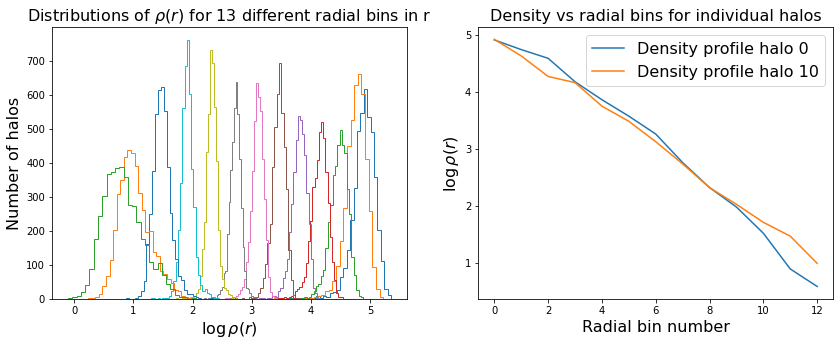

In [8]:
r_bins = truth.shape[0]
f, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_xlabel(r"$\log \rho(r)$", fontsize=16)
axes[0].set_ylabel("Number of halos", fontsize=16)
for i in range(r_bins):
    _ = axes[0].hist(truth[i], bins=30, histtype="step")
axes[0].set_title(rf"Distributions of $\rho(r)$ for {r_bins} different radial bins in r", fontsize=16)

axes[1].plot(truth[:,0], label="Density profile halo 0")
axes[1].plot(truth[:,10], label="Density profile halo 10")
axes[1].set_ylabel(r"$\log \rho(r)$", fontsize=16)
axes[1].set_xlabel("Radial bin number", fontsize=16)
axes[1].legend(loc="best", fontsize=16)
axes[1].set_title("Density vs radial bins for individual halos", fontsize=16);

In [9]:
# Each halo has 3 associated Gaussian latent distributions. These are means and standard deviations of the latents.
# lmean and lstd are MxN arrays where M is the number of halos and N is the number of latents (3 in this case).
# For example, lmean[0], lstd[0] give you the means and standard deviations of the 3 latent distributions for halos 0.
# lmean[:, 0], lstd[:, 0] give you the mean and standard deviations for all halos for latent 0.

epoch = 27

lmean, lstd = np.load(f"./latent_mean_11_testset_epoch_{epoch}.npy"), np.load(f"./latent_std_11_testset_epoch_{epoch}.npy")

In [10]:
# To obtain the distribution of latents from the set of means/std-devs, one has to sample from each Gaussian
# e.g. to sample from latent 0, you can do (the second should be faster, but equivalent):
#samples = np.random.multivariate_normal(lmean[:, 0], np.diag(lstd[:, 0])**2, 1).reshape(len(lmean[:,0]))
latent_var = 0
samples = np.random.default_rng(42).normal(lmean[:, latent_var], lstd[:, latent_var], len(lmean[:, latent_var]))

# Note that this is the mixture distribution of each latent, i.e. this is e.g. p(z0) = int p(z0|x)p(x)dx, 
# where each p(z0|x) is a gaussian distribution. This explains why the distribution of samples is not
# necessarily a gaussian distribution

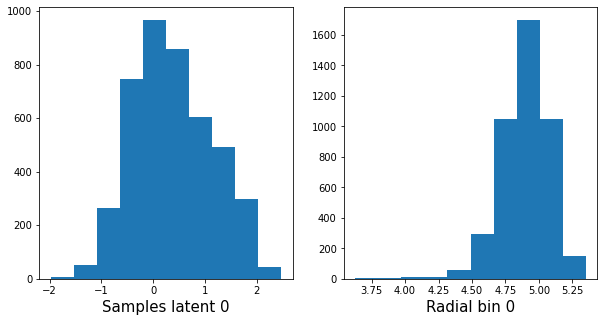

In [11]:
# Just some plots to show some distributions of interest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples)
ax1.set_xlabel('Samples latent 0', fontsize=15);
ax2.hist(truth[0])
ax2.set_xlabel('Radial bin 0', fontsize=15);

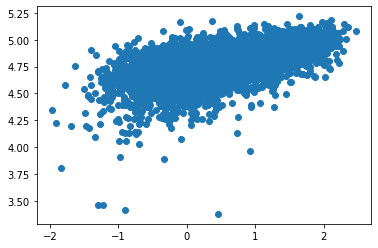

In [12]:
X = np.stack((samples, truth[1]), axis=0).T
plt.scatter(X[:, 0], X[:, 1]);

### New procedure with different convergence criterion

In [13]:
# now we do this for many components, from 1 to 5
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-6
components_range = 10
all_MI_estimates = np.zeros((components_range, n_bootstrap))

best_val = -np.inf

initial_time = time.time()
for n_components in range(1, components_range+1):
    current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                       init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                       MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
    
    # check if convergence has been reached based on val score
    if current_val > best_val:
        best_val = current_val
        best_seed = current_seed
        print(n_components, best_val)
    else:
        # if val score has not increased, then we should stop and calculate MI with the previous parameters
        best_components = n_components-1
        print(f'Convergence reached at {best_components} components') 
        w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
        MI_estimates = np.zeros(n_bootstrap)

        # bootstrap available samples
        for i in range(n_bootstrap):
            # we use i to change the seed so that the results will be fully reproducible
            rng = np.random.default_rng(i)
            X_bs = rng.choice(X, X.shape[0])
            gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                        tol=tol, max_iter=10000, 
                        random_state=best_seed, weights_init=w_init, 
                        means_init=m_init, precisions_init=p_init).fit(X_bs)


            current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
            MI_estimates[i] = current_MI_estimate

        print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
        break

print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')

1 -0.677762216045501
2 -0.6234194630312603
3 -0.5955337745251613
4 -0.5913289720560347
5 -0.5871946007993717
6 -0.5866106445714374
Convergence reached at 6 components
6 0.19231214133646776 0.007882548716695349
Total time to run the procedure: 173.87 s


In [90]:
# check if removing regularisation changes anything!
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-5
reg_covar = 0
components_range = 15
all_MI_estimates = np.zeros((components_range, n_bootstrap))

best_val = -np.inf

initial_time = time.time()
for n_components in range(1, components_range+1):
    current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                       init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                       MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
    
    # check if convergence has been reached based on val score
    if current_val > best_val:
        best_val = current_val
        best_seed = current_seed
        print(n_components, best_val)
    else:
        # if val score has not increased, then we should stop and calculate MI with the previous parameters
        best_components = n_components-1
        print(f'Convergence reached at {best_components} components') 
        w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
        MI_estimates = np.zeros(n_bootstrap)

        # bootstrap available samples
        for i in range(n_bootstrap):
            # we use i to change the seed so that the results will be fully reproducible
            rng = np.random.default_rng(i)
            X_bs = rng.choice(X, X.shape[0])
            gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                        tol=tol, max_iter=10000, 
                        random_state=best_seed, weights_init=w_init, 
                        means_init=m_init, precisions_init=p_init).fit(X_bs)


            current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
            MI_estimates[i] = current_MI_estimate

        print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
        #break

print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')

1 -0.6186492747724021
2 -0.5561362058465793
[[0.57656173 0.07376834]
 [0.07376834 0.02953045]]
[[0.57636057 0.07265895]
 [0.07265895 0.02788491]]
[[0.57471934 0.06998701]
 [0.06998701 0.02511852]]
[[0.57389293 0.06735054]
 [0.06735054 0.02261141]]
[[0.57462181 0.06559425]
 [0.06559425 0.02097306]]
[[0.57619775 0.06456428]
 [0.06456428 0.02002702]]
[[0.57781999 0.06392094]
 [0.06392094 0.01949588]]
[[0.57910223 0.06344424]
 [0.06344424 0.01919659]]
[[0.57995028 0.06302358]
 [0.06302358 0.01902725]]
[[0.58039504 0.06260666]
 [0.06260666 0.01893323]]
[[0.58050089 0.06216646]
 [0.06216646 0.01888474]]
[[0.58032866 0.06168539]
 [0.06168539 0.0188646 ]]
[[0.57992416 0.0611489 ]
 [0.0611489  0.01886212]]
[[0.57931603 0.06054353]
 [0.06054353 0.01886992]]
[[0.57851553 0.05985688]
 [0.05985688 0.01888251]]
[[0.57751613 0.05907846]
 [0.05907846 0.0188955 ]]
[[0.57629288 0.05820096]
 [0.05820096 0.01890524]]
[[0.57480324 0.05722174]
 [0.05722174 0.01890875]]
[[0.57299149 0.0561441 ]
 [0.0561441  

[[0.32133417 0.01074516]
 [0.01074516 0.01346676]]
[[0.31944959 0.01089658]
 [0.01089658 0.01353862]]
[[0.31758098 0.0110682 ]
 [0.0110682  0.01361368]]
[[0.31573501 0.01126093]
 [0.01126093 0.01369198]]
[[0.3139185  0.01147554]
 [0.01147554 0.01377357]]
[[0.31213824 0.01171267]
 [0.01171267 0.01385847]]
[[0.31040081 0.0119728 ]
 [0.0119728  0.01394666]]
[[0.30871236 0.01225618]
 [0.01225618 0.01403811]]
[[0.30707839 0.01256289]
 [0.01256289 0.01413278]]
[[0.30550352 0.01289278]
 [0.01289278 0.01423059]]
[[0.30399127 0.01324544]
 [0.01324544 0.01433143]]
[[0.30254384 0.01362027]
 [0.01362027 0.0144352 ]]
[[0.30116196 0.01401643]
 [0.01401643 0.01454174]]
[[0.29984478 0.01443288]
 [0.01443288 0.01465092]]
[[0.29858978 0.01486839]
 [0.01486839 0.01476257]]
[[0.29739284 0.01532155]
 [0.01532155 0.0148765 ]]
[[0.2962483  0.01579083]
 [0.01579083 0.01499255]]
[[0.29514915 0.01627453]
 [0.01627453 0.0151105 ]]
[[0.29408735 0.01677088]
 [0.01677088 0.01523014]]
[[0.2930542  0.01727793]
 [0.01

[[0.24090391 0.02307694]
 [0.02307694 0.01867213]]
[[0.24178793 0.02324756]
 [0.02324756 0.01867225]]
[[0.24269193 0.0234138 ]
 [0.0234138  0.01867216]]
[[0.24361431 0.02357611]
 [0.02357611 0.01867194]]
[[0.24455366 0.02373491]
 [0.02373491 0.01867165]]
[[0.24550867 0.02389057]
 [0.02389057 0.01867136]]
[[0.24647816 0.02404343]
 [0.02404343 0.01867111]]
[[0.24746104 0.02419378]
 [0.02419378 0.01867094]]
[[0.24845629 0.0243419 ]
 [0.0243419  0.01867089]]
[[0.24946293 0.02448801]
 [0.02448801 0.01867099]]
[[0.25048006 0.0246323 ]
 [0.0246323  0.01867126]]
[[0.2515068  0.02477496]
 [0.02477496 0.01867172]]
[[0.2525423  0.02491613]
 [0.02491613 0.01867239]]
[[0.25358573 0.02505594]
 [0.02505594 0.01867327]]
[[0.25463629 0.02519448]
 [0.02519448 0.01867438]]
[[0.25569316 0.02533184]
 [0.02533184 0.01867572]]
[[0.25675557 0.02546809]
 [0.02546809 0.01867729]]
[[0.25782272 0.02560328]
 [0.02560328 0.0186791 ]]
[[0.25889383 0.02573743]
 [0.02573743 0.01868114]]
[[0.25996811 0.02587058]
 [0.02

[[0.47456794 0.03575715]
 [0.03575715 0.01338742]]
[[0.4736088  0.03555493]
 [0.03555493 0.01337244]]
[[0.47264123 0.03535207]
 [0.03535207 0.01335794]]
[[0.47166479 0.03514848]
 [0.03514848 0.01334389]]
[[0.47067907 0.03494407]
 [0.03494407 0.01333026]]
[[0.46968362 0.03473876]
 [0.03473876 0.01331706]]
[[0.46867798 0.03453245]
 [0.03453245 0.01330425]]
[[0.46766167 0.03432504]
 [0.03432504 0.01329183]]
[[0.46663422 0.03411645]
 [0.03411645 0.01327978]]
[[0.46559511 0.03390659]
 [0.03390659 0.0132681 ]]
[[0.46454383 0.03369536]
 [0.03369536 0.01325678]]
[[0.46347985 0.03348266]
 [0.03348266 0.0132458 ]]
[[0.46240262 0.0332684 ]
 [0.0332684  0.01323517]]
[[0.46131158 0.03305249]
 [0.03305249 0.01322488]]
[[0.46020614 0.03283483]
 [0.03283483 0.01321492]]
[[0.45908571 0.03261532]
 [0.03261532 0.0132053 ]]
[[0.45794968 0.03239387]
 [0.03239387 0.01319602]]
[[0.45679741 0.03217038]
 [0.03217038 0.01318707]]
[[0.45562824 0.03194474]
 [0.03194474 0.01317846]]
[[0.45444152 0.03171687]
 [0.03

[[0.5305581  0.04244625]
 [0.04244625 0.01866451]]
[[0.52672944 0.04183832]
 [0.04183832 0.01865656]]
[[0.52321932 0.04134042]
 [0.04134042 0.0186347 ]]
[[0.52005781 0.04094024]
 [0.04094024 0.01859907]]
[[0.51725323 0.04062236]
 [0.04062236 0.01855014]]
[[0.51479545 0.04037014]
 [0.04037014 0.01848859]]
[[0.5126603  0.04016718]
 [0.04016718 0.01841521]]
[[0.51081432 0.03999843]
 [0.03999843 0.01833084]]
[[0.50921907 0.03985074]
 [0.03985074 0.01823631]]
[[0.50783461 0.03971306]
 [0.03971306 0.01813248]]
[[0.50662205 0.03957647]
 [0.03957647 0.01802019]]
[[0.50554511 0.03943392]
 [0.03943392 0.01790027]]
[[0.50457104 0.03928012]
 [0.03928012 0.01777355]]
[[0.503671   0.03911116]
 [0.03911116 0.01764081]]
[[0.50282009 0.03892433]
 [0.03892433 0.01750284]]
[[0.50199716 0.03871789]
 [0.03871789 0.01736035]]
[[0.50118452 0.03849085]
 [0.03849085 0.01721404]]
[[0.50036753 0.03824279]
 [0.03824279 0.01706455]]
[[0.49953428 0.03797375]
 [0.03797375 0.01691246]]
[[0.49867521 0.03768414]
 [0.03

[[0.28709543 0.02074402]
 [0.02074402 0.01615912]]
[[0.28610172 0.02124419]
 [0.02124419 0.01627994]]
[[0.28511454 0.02172895]
 [0.02172895 0.01639868]]
[[0.28414228 0.02219447]
 [0.02219447 0.01651466]]
[[0.2831938  0.02263723]
 [0.02263723 0.01662718]]
[[0.28227734 0.02305428]
 [0.02305428 0.01673558]]
[[0.28139971 0.02344332]
 [0.02344332 0.01683922]]
[[0.28056566 0.02380284]
 [0.02380284 0.01693758]]
[[0.27977778 0.02413212]
 [0.02413212 0.01703025]]
[[0.2790366  0.02443113]
 [0.02443113 0.01711696]]
[[0.27834092 0.02470052]
 [0.02470052 0.0171976 ]]
[[0.27768824 0.02494141]
 [0.02494141 0.01727216]]
[[0.27707526 0.02515531]
 [0.02515531 0.01734078]]
[[0.27649827 0.02534399]
 [0.02534399 0.01740367]]
[[0.27595345 0.02550936]
 [0.02550936 0.01746111]]
[[0.27543714 0.0256534 ]
 [0.0256534  0.01751342]]
[[0.27494597 0.02577809]
 [0.02577809 0.01756097]]
[[0.27447691 0.02588532]
 [0.02588532 0.01760412]]
[[0.27402736 0.02597692]
 [0.02597692 0.01764322]]
[[0.27359505 0.02605459]
 [0.02

[[0.2528498  0.02494757]
 [0.02494757 0.01867301]]
[[0.25389382 0.02508811]
 [0.02508811 0.01867405]]
[[0.25494492 0.02522728]
 [0.02522728 0.0186753 ]]
[[0.25600226 0.02536515]
 [0.02536515 0.01867676]]
[[0.25706505 0.02550182]
 [0.02550182 0.01867843]]
[[0.25813247 0.02563734]
 [0.02563734 0.01868033]]
[[0.25920372 0.02577175]
 [0.02577175 0.01868245]]
[[0.26027801 0.02590508]
 [0.02590508 0.0186848 ]]
[[0.26135453 0.02603735]
 [0.02603735 0.01868735]]
[[0.26243248 0.02616856]
 [0.02616856 0.01869013]]
[[0.26351106 0.02629871]
 [0.02629871 0.0186931 ]]
[[0.26458944 0.02642779]
 [0.02642779 0.01869628]]
[[0.26566683 0.02655576]
 [0.02655576 0.01869965]]
[[0.26674241 0.02668261]
 [0.02668261 0.01870321]]
[[0.26781536 0.02680829]
 [0.02680829 0.01870694]]
[[0.26888486 0.02693277]
 [0.02693277 0.01871084]]
[[0.26995011 0.027056  ]
 [0.027056   0.01871489]]
[[0.27101029 0.02717793]
 [0.02717793 0.01871909]]
[[0.27206459 0.02729851]
 [0.02729851 0.01872342]]
[[0.27311223 0.0274177 ]
 [0.02

[[0.45718316 0.03196826]
 [0.03196826 0.01330731]]
[[0.45601224 0.03174669]
 [0.03174669 0.01329769]]
[[0.45482246 0.03152254]
 [0.03152254 0.01328855]]
[[0.45361302 0.0312957 ]
 [0.0312957  0.01327989]]
[[0.45238311 0.03106603]
 [0.03106603 0.01327169]]
[[0.45113188 0.03083342]
 [0.03083342 0.01326395]]
[[0.44985848 0.03059775]
 [0.03059775 0.01325666]]
[[0.44856202 0.0303589 ]
 [0.0303589  0.01324982]]
[[0.44724161 0.03011676]
 [0.03011676 0.01324343]]
[[0.44589631 0.0298712 ]
 [0.0298712  0.01323751]]
[[0.44452517 0.02962211]
 [0.02962211 0.01323205]]
[[0.44312722 0.02936938]
 [0.02936938 0.01322707]]
[[0.44170145 0.02911288]
 [0.02911288 0.01322258]]
[[0.44024684 0.02885252]
 [0.02885252 0.0132186 ]]
[[0.43876235 0.02858817]
 [0.02858817 0.01321513]]
[[0.43724689 0.02831973]
 [0.02831973 0.01321221]]
[[0.43569937 0.0280471 ]
 [0.0280471  0.01320986]]
[[0.43411867 0.02777017]
 [0.02777017 0.01320811]]
[[0.43250364 0.02748885]
 [0.02748885 0.01320697]]
[[0.43085312 0.02720305]
 [0.02

[[0.19280604 0.02432329]
 [0.02432329 0.04397183]]
[[0.19313736 0.0243885 ]
 [0.0243885  0.04407021]]
[[0.19348335 0.02445526]
 [0.02445526 0.04416706]]
[[0.19384073 0.02452311]
 [0.02452311 0.04426221]]
[[0.19420656 0.0245916 ]
 [0.0245916  0.0443555 ]]
[[0.19457822 0.02466037]
 [0.02466037 0.04444681]]
[[0.19495337 0.02472909]
 [0.02472909 0.04453601]]
[[0.19532992 0.02479745]
 [0.02479745 0.04462301]]
[[0.19570599 0.02486522]
 [0.02486522 0.04470772]]
[[0.19607995 0.02493216]
 [0.02493216 0.04479008]]
[[0.19645033 0.02499811]
 [0.02499811 0.04487002]]
[[0.19681585 0.02506291]
 [0.02506291 0.0449475 ]]
[[0.1971754  0.02512644]
 [0.02512644 0.04502251]]
[[0.197528   0.02518858]
 [0.02518858 0.04509501]]
[[0.19787285 0.02524928]
 [0.02524928 0.045165  ]]
[[0.19820925 0.02530848]
 [0.02530848 0.0452325 ]]
[[0.19853663 0.02536613]
 [0.02536613 0.04529751]]
[[0.19885454 0.02542223]
 [0.02542223 0.04536006]]
[[0.19916263 0.02547676]
 [0.02547676 0.04542019]]
[[0.19946064 0.02552974]
 [0.02

[[0.6031436  0.08278777]
 [0.08278777 0.03800119]]
[[0.60489497 0.08956599]
 [0.08956599 0.04445518]]
[[0.59677324 0.09247442]
 [0.09247442 0.0485289 ]]
[[0.58069299 0.09169663]
 [0.09169663 0.0502521 ]]
[[0.56086379 0.08883336]
 [0.08883336 0.05058964]]
[[0.54015348 0.08508226]
 [0.08508226 0.05028086]]
[[0.51991574 0.08109473]
 [0.08109473 0.04975132]]
[[0.50059716 0.07715758]
 [0.07715758 0.04920565]]
[[0.48224684 0.07337284]
 [0.07337284 0.04872486]]
[[0.46479369 0.06976781]
 [0.06976781 0.04833114]]
[[0.44816404 0.06634759]
 [0.06634759 0.04802267]]
[[0.43231844 0.06311522]
 [0.06311522 0.04778981]]
[[0.4172537  0.06007693]
 [0.06007693 0.04762183]]
[[0.40299144 0.05724175]
 [0.05724175 0.04750928]]
[[0.38956219 0.0546193 ]
 [0.0546193  0.04744452]]
[[0.37698929 0.05221766]
 [0.05221766 0.0474216 ]]
[[0.36527562 0.0500415 ]
 [0.0500415  0.04743596]]
[[0.35439516 0.04809118]
 [0.04809118 0.04748411]]
[[0.34429044 0.04636241]
 [0.04636241 0.04756332]]
[[0.33487551 0.04484665]
 [0.04

[[0.67585896 0.14175726]
 [0.14175726 0.08157219]]
[[0.67581293 0.14179338]
 [0.14179338 0.08159218]]
[[0.67576769 0.14182831]
 [0.14182831 0.08161195]]
[[0.67572314 0.14186205]
 [0.14186205 0.08163149]]
[[0.67567918 0.14189459]
 [0.14189459 0.08165078]]
[[0.67563576 0.14192592]
 [0.14192592 0.08166979]]
[[0.6755928  0.14195603]
 [0.14195603 0.08168851]]
[[0.67555027 0.14198494]
 [0.14198494 0.08170693]]
[[0.57815547 0.07129283]
 [0.07129283 0.03135981]]
[[0.58031341 0.0756485 ]
 [0.0756485  0.03648254]]
[[0.57964056 0.08084787]
 [0.08084787 0.04190901]]
[[0.57032652 0.08349212]
 [0.08349212 0.04551434]]
[[0.55214512 0.08278375]
 [0.08278375 0.04708085]]
[[0.52863082 0.07975077]
 [0.07975077 0.04731353]]
[[0.50307626 0.07551131]
 [0.07551131 0.04686795]]
[[0.47739887 0.07079402]
 [0.07079402 0.04616043]]
[[0.45245961 0.06598663]
 [0.06598663 0.04541071]]
[[0.42857395 0.0612766 ]
 [0.0612766  0.04471811]]
[[0.40585281 0.05675665]
 [0.05675665 0.04411932]]
[[0.38436803 0.05248157]
 [0.05

[[0.23670468 0.03009706]
 [0.03009706 0.06187505]]
[[0.23802212 0.03033589]
 [0.03033589 0.06211236]]
[[0.23941883 0.03058394]
 [0.03058394 0.06235777]]
[[0.24090128 0.03084145]
 [0.03084145 0.06261167]]
[[0.24247663 0.03110863]
 [0.03110863 0.06287447]]
[[0.24415277 0.03138565]
 [0.03138565 0.06314661]]
[[0.24593842 0.03167267]
 [0.03167267 0.06342851]]
[[0.24784319 0.03196983]
 [0.03196983 0.06372061]]
[[0.24987772 0.03227721]
 [0.03227721 0.06402334]]
[[0.25205368 0.03259488]
 [0.03259488 0.06433712]]
[[0.25438389 0.03292287]
 [0.03292287 0.06466234]]
[[0.25688234 0.03326117]
 [0.03326117 0.06499934]]
[[0.25956418 0.03360972]
 [0.03360972 0.0653484 ]]
[[0.26244572 0.03396844]
 [0.03396844 0.06570972]]
[[0.26554427 0.0343372 ]
 [0.0343372  0.06608339]]
[[0.26887797 0.03471581]
 [0.03471581 0.06646936]]
[[0.27246546 0.03510406]
 [0.03510406 0.06686738]]
[[0.27632542 0.03550173]
 [0.03550173 0.06727704]]
[[0.28047603 0.03590854]
 [0.03590854 0.06769766]]
[[0.28493418 0.03632423]
 [0.03

[[0.20405043 0.02646814]
 [0.02646814 0.04632259]]
[[0.20417247 0.02650021]
 [0.02650021 0.04634606]]
[[0.20429319 0.02653229]
 [0.02653229 0.04636915]]
[[0.20441292 0.02656441]
 [0.02656441 0.04639191]]
[[0.204532   0.02659662]
 [0.02659662 0.04641438]]
[[0.20465073 0.02662895]
 [0.02662895 0.04643661]]
[[0.20476941 0.02666144]
 [0.02666144 0.04645863]]
[[0.20488832 0.02669413]
 [0.02669413 0.04648049]]
[[0.20500773 0.02672705]
 [0.02672705 0.04650222]]
[[0.2051279  0.02676023]
 [0.02676023 0.04652386]]
[[0.20524907 0.02679371]
 [0.02679371 0.04654544]]
[[0.20537148 0.02682751]
 [0.02682751 0.04656698]]
[[0.20549535 0.02686167]
 [0.02686167 0.04658852]]
[[0.20562091 0.02689622]
 [0.02689622 0.0466101 ]]
[[0.20574837 0.02693119]
 [0.02693119 0.04663172]]
[[0.20587794 0.02696661]
 [0.02696661 0.04665343]]
[[0.20600983 0.02700252]
 [0.02700252 0.04667525]]
[[0.20614424 0.02703894]
 [0.02703894 0.04669719]]
[[0.20628137 0.02707591]
 [0.02707591 0.0467193 ]]
[[0.20642143 0.02711345]
 [0.02

[[0.21320938 0.03859735]
 [0.03859735 0.05372504]]
[[0.21190065 0.03880461]
 [0.03880461 0.0541349 ]]
[[0.2109086  0.03904071]
 [0.03904071 0.05456085]]
[[0.21020326 0.03930674]
 [0.03930674 0.05500363]]
[[0.20975851 0.03960343]
 [0.03960343 0.05546391]]
[[0.20955228 0.03993121]
 [0.03993121 0.0559424 ]]
[[0.20956658 0.04029036]
 [0.04029036 0.05643977]]
[[0.20978728 0.04068101]
 [0.04068101 0.05695672]]
[[0.21020389 0.04110331]
 [0.04110331 0.05749397]]
[[0.21080925 0.0415574 ]
 [0.0415574  0.05805224]]
[[0.21159934 0.04204346]
 [0.04204346 0.05863226]]
[[0.21257299 0.04256175]
 [0.04256175 0.05923474]]
[[0.21373171 0.04311256]
 [0.04311256 0.05986035]]
[[0.21507951 0.04369622]
 [0.04369622 0.0605097 ]]
[[0.21662268 0.04431307]
 [0.04431307 0.06118328]]
[[0.2183696  0.0449634 ]
 [0.0449634  0.06188142]]
[[0.22033047 0.04564738]
 [0.04564738 0.06260423]]
[[0.22251693 0.04636501]
 [0.04636501 0.06335153]]
[[0.22494162 0.04711597]
 [0.04711597 0.0641228 ]]
[[0.22761754 0.04789954]
 [0.04

KeyboardInterrupt: 

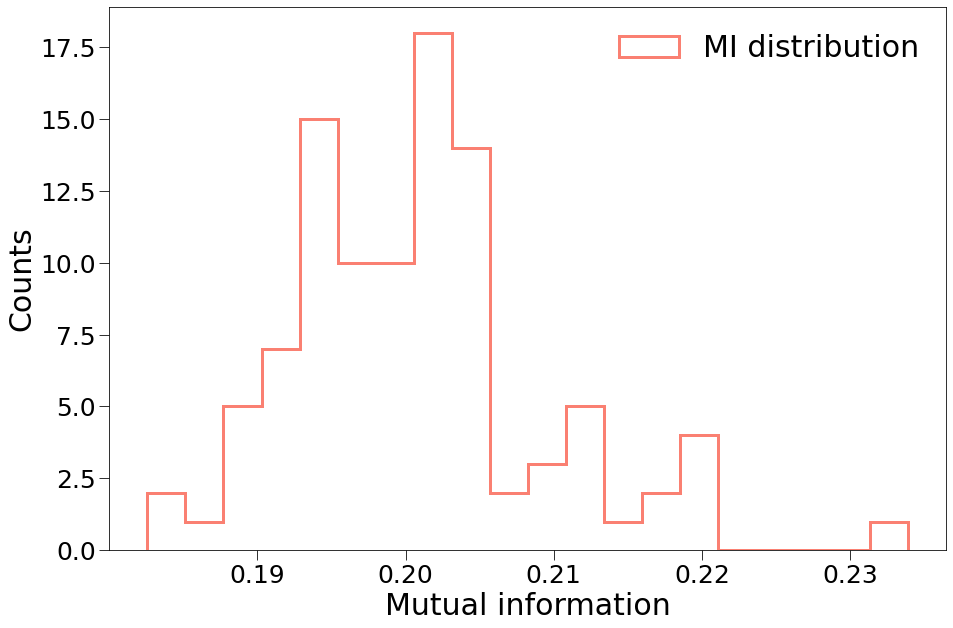

In [38]:
bins = 20

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.hist(MI_estimates, histtype='step', color='salmon', lw=3, bins=bins, label='MI distribution')


ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30);

### Test on what happens to the training and loss curve for a single fit

In [183]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        #self.covariance_type = covariance_type
        #self.precisions_cholesky_ = _compute_precision_cholesky(
        #        self.covariances_, self.covariance_type
        #    )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI

    def fit(self, X, y=None, X_valid=None, return_loss=False):
        """Estimate model parameters with the EM algorithm.
        The method fits the model ``n_init`` times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for ``max_iter``
        times until the change of likelihood or lower bound is less than
        ``tol``, otherwise, a ``ConvergenceWarning`` is raised.
        If ``warm_start`` is ``True``, then ``n_init`` is ignored and a single
        initialization is performed upon the first call. Upon consecutive
        calls, training starts where it left off.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        self : object
            The fitted mixture.
        """
        self.fit_predict(X, y, X_valid, return_loss)
        return self
    
    def fit_predict(self, X, y=None, X_valid=None, return_loss=False):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        #X = X_valid
        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_
            
            self.loss_values = []
            for n_iter in range(1, self.max_iter + 1):
                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                if return_loss:
                    if X_valid is not None:
                        log_prob_norm_valid, _ = self._estimate_log_prob_resp(X_valid)
                        log_prob_norm_valid = np.mean(log_prob_norm_valid)
                        self.loss_values.append((lower_bound, log_prob_norm_valid))
                        # would need to set the change based on validation data, if they are available!
                        #lower_bound = log_prob_norm_valid
                    else:
                        self.loss_values.append(lower_bound)
                
                self._m_step(X, log_resp)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [198]:
latent_number = 2
radial_bin = 12
samples = np.random.default_rng(42).normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

X = np.stack((samples, truth[radial_bin]), axis=0).T

n_components = 2
tol = 1e-5
w_init, m_init, c_init, p_init = initialize_parameters(X, random_state=0, n_components=n_components, init_type='random_sklearn')

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# fix the random seed first
for r in range(n_inits):

    w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
    validation_scores = []

    for train_indices, valid_indices in kf.split(X):
        X_training = X[train_indices]
        X_validation = X[valid_indices]
    
    fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=0, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X_training, X_valid=X_validation, return_loss=True)
    
    break
    


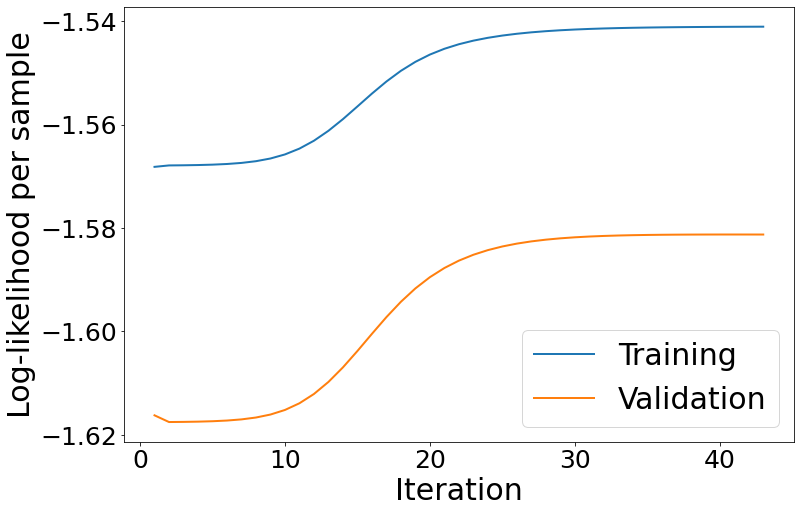

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
loss_values = np.array(fitted_gmm.loss_values)

ax.plot(np.arange(1, len(loss_values)+1), loss_values[:, 0], label='Training', lw=2)
ax.plot(np.arange(1, len(loss_values)+1), loss_values[:, 1], label='Validation', lw=2)

ax.set_xlabel('Iteration', fontsize=30)
ax.set_ylabel(r"Log-likelihood per sample", fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30);

In [189]:
latent_number = 2
radial_bin = 10
samples = np.random.default_rng(42).normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

X = np.stack((samples, truth[radial_bin]), axis=0).T

n_components = 2
tol = 1e-5
w_init, m_init, c_init, p_init = initialize_parameters(X, random_state=0, n_components=n_components, init_type='random_sklearn')

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# fix the random seed first
for r in range(n_inits):

    w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
    validation_scores = []

    for train_indices, valid_indices in kf.split(X):
        X_training = X[train_indices]
        X_validation = X[valid_indices]
    
    fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=0, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X_training, X_valid=X_validation, return_loss=True)
    
    break
    


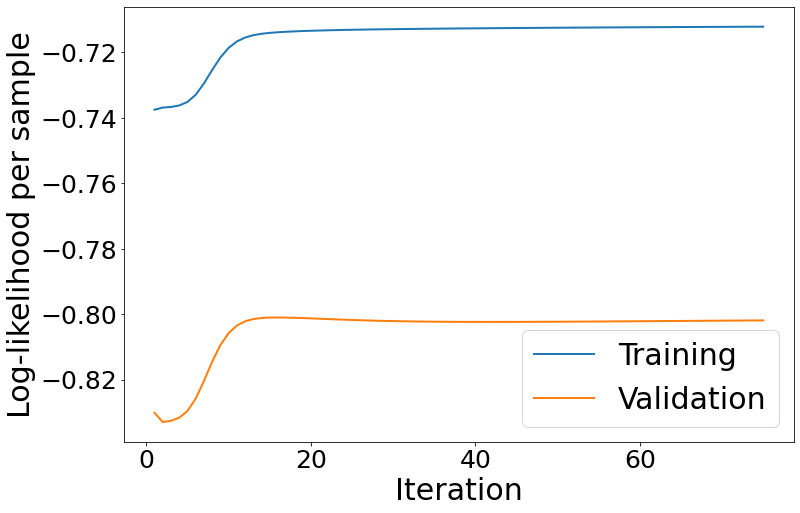

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
loss_values = np.array(fitted_gmm.loss_values)

ax.plot(np.arange(1, len(loss_values)+1), loss_values[:, 0], label='Training', lw=2)
ax.plot(np.arange(1, len(loss_values)+1), loss_values[:, 1], label='Validation', lw=2)

ax.set_xlabel('Iteration', fontsize=30)
ax.set_ylabel(r"Log-likelihood per sample", fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30);

### Now, let's look at KDE fits on a few samples

In [217]:
# A different approach is to use the fact that mutual information is defined as the KL divergence 
# between the joint distribution of two random variables p(x,y) and the product of their marginals p(x)p(y).
# I use KDEs to turn a set of discrete samples into continuous distributions

def mutual_information_cont(x, y, xlow=9, xhigh=16, ylow=9, yhigh=16, bandwidth=0.1):
    # KL divergence between joint probability distribution p(x, y) and the product of their marginals p(x)p(y).
    pxy = kde2D(x, y, bandwidth)
    print("Fitted 2D kde to joint distributions")
    px = kde1D(x, bandwidth)
    py = kde1D(y, bandwidth)
    print("Fitted 1D kdes for each marginal distributions")
    return KL_div_continuous(pxy, px, py, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)


def kde1D(x, bandwidth, **kwargs):
    """Build 1D kernel density estimate (KDE)."""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl = kde_skl.fit(x.reshape(-1, 1))
    return kde_skl


def evaluate_kde1d(fitted_kde, xx):
    """Evaluate fitted 1D KDE at position xx."""
    z = np.exp(fitted_kde.score_samples(np.array([xx]).reshape(-1, 1)))
    return z


def kde2D(x, y, bandwidth, **kwargs):
    """Build 2D kernel density estimate (KDE)."""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.vstack([y, x]).T)
    return kde_skl


def evaluate_kde2d(fitted_kde, xx, yy):
    """Evaluate fitted 2D KDE at position xx."""
    xy_sample = np.vstack([yy, xx]).T
    z = np.exp(fitted_kde.score_samples(xy_sample))
    return z


def integrand(fitted_pxy, fitted_px, fitted_py, x, y):
    pxy = evaluate_kde2d(fitted_pxy, x, y)
    px = evaluate_kde1d(fitted_px, x)
    py = evaluate_kde1d(fitted_py, y)
    nsz = pxy != 0
    return pxy[nsz] * np.log(pxy[nsz] / (px[nsz] * py[nsz]))


def KL_div_continuous(fitted_pxy, fitted_px, fitted_py, xlow=9, xhigh=16, ylow=9, yhigh=16):
    func = lambda y, x: integrand(fitted_pxy, fitted_px, fitted_py, x, y)
    return integrate.dblquad(func, xlow, xhigh, lambda x: ylow, lambda x: yhigh)

def normalise(X):
    return (X - np.mean(X))/np.std(X)

In [263]:
latent_number = 0
samples1 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))
latent_number = 1
samples2 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

bw = 0.2

X = np.stack((samples1, samples2), axis=0).T

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()

mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]


Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions


0.07259258250353734

In [268]:
bw = 0.3

print(mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0])

bw = 0.1

print(mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0])


Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
0.0577686163035704
Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
0.09861179347817722


In [264]:
latent_number = 0
samples1 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))
latent_number = 2
samples2 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

bw = 0.2

X = np.stack((samples1, samples2), axis=0).T

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()

mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]


Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions


0.030650826154068122

In [265]:
latent_number = 1
samples1 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))
latent_number = 2
samples2 = np.random.default_rng().normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

bw = 0.2

X = np.stack((samples1, samples2), axis=0).T

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()

mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]


Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions


0.018449264174621963

In [303]:
latent_number = 0
radial_bin = 12
samples = np.random.default_rng(42).normal(lmean[:, latent_number], lstd[:, latent_number], len(lmean[:, latent_number]))

X = np.stack((samples, truth[radial_bin]), axis=0).T

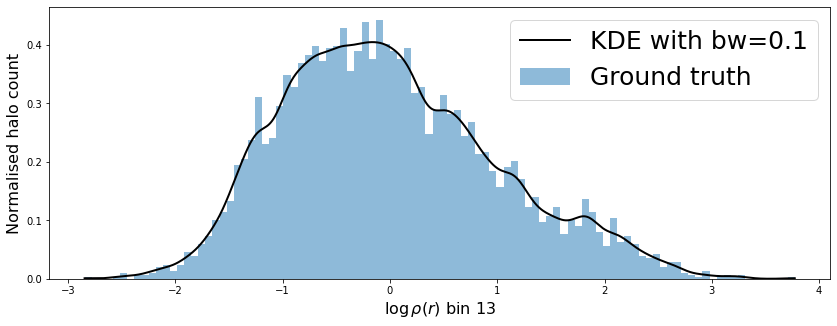

In [304]:
# check behaviour with different bandwidth values

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
bw = 0.1

f, axes = plt.subplots(1, 1, figsize=(14, 5))

kde_skl = kde1D(normalise(X[:, 1]), bw)
#kde_skl = kde_skl.fit(normalise(X[:, 1]).reshape(-1, 1))

y_plot = np.linspace(ylow, yhigh, 1000)[:, np.newaxis]
y_truth = evaluate_kde1d(kde_skl, y_plot)

_ = axes.hist(normalise(X[:, 1]), 100, density=True, label="Ground truth", alpha=0.5)
axes.plot(y_plot, y_truth, color="k", lw=2, label=f'KDE with bw={bw}')

axes.set_xlabel(r"$\log \rho(r)$ bin 13", fontsize=16)
axes.set_ylabel("Normalised halo count", fontsize=16)
axes.legend(fontsize=25);

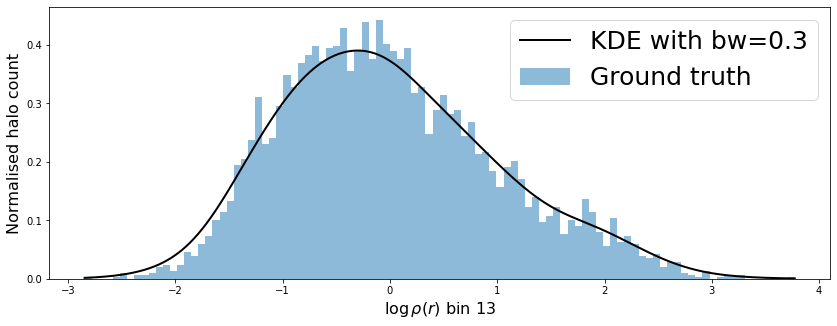

In [305]:
# check behaviour with different bandwidth values

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
bw = 0.3

f, axes = plt.subplots(1, 1, figsize=(14, 5))

kde_skl = kde1D(normalise(X[:, 1]), bw)
#kde_skl = kde_skl.fit(normalise(X[:, 1]).reshape(-1, 1))

y_plot = np.linspace(ylow, yhigh, 1000)[:, np.newaxis]
y_truth = evaluate_kde1d(kde_skl, y_plot)

_ = axes.hist(normalise(X[:, 1]), 100, density=True, label="Ground truth", alpha=0.5)
axes.plot(y_plot, y_truth, color="k", lw=2, label=f'KDE with bw={bw}')

axes.set_xlabel(r"$\log \rho(r)$ bin 13", fontsize=16)
axes.set_ylabel("Normalised halo count", fontsize=16)
axes.legend(fontsize=25);

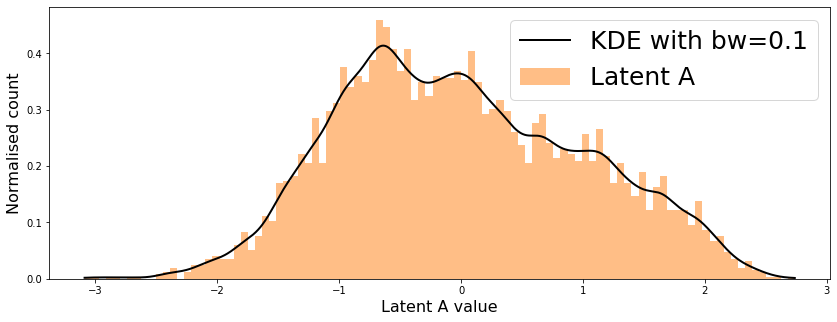

In [301]:
# check behaviour with different bandwidth values

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
bw = 0.1

f, axes = plt.subplots(1, 1, figsize=(14, 5))

kde_skl = kde1D(normalise(X[:, 0]), bw)
#kde_skl = kde_skl.fit(normalise(X[:, 0]).reshape(-1, 1))

y_plot = np.linspace(xlow, xhigh, 1000)[:, np.newaxis]
y_truth = evaluate_kde1d(kde_skl, y_plot)

_ = axes.hist(normalise(X[:, 0]), 100, density=True, label="Latent A", alpha=0.5, color='C1')
axes.plot(y_plot, y_truth, color="k", lw=2, label=f'KDE with bw={bw}')

axes.set_xlabel(r"Latent A value", fontsize=16)
axes.set_ylabel("Normalised count", fontsize=16)
axes.legend(fontsize=25);

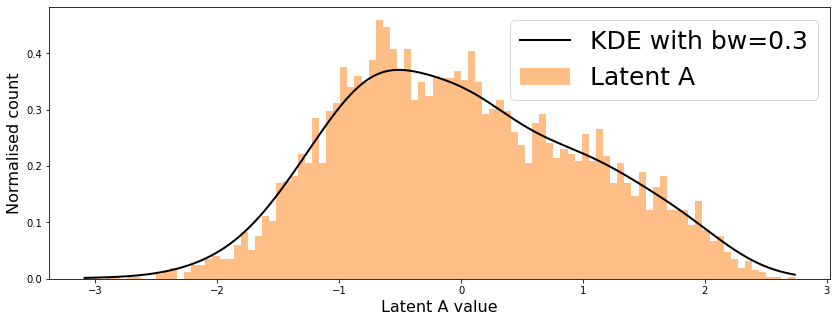

In [302]:
# check behaviour with different bandwidth values

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
bw = 0.3

f, axes = plt.subplots(1, 1, figsize=(14, 5))

kde_skl = kde1D(normalise(X[:, 0]), bw)
#kde_skl = kde_skl.fit(normalise(X[:, 0]).reshape(-1, 1))

y_plot = np.linspace(xlow, xhigh, 1000)[:, np.newaxis]
y_truth = evaluate_kde1d(kde_skl, y_plot)

_ = axes.hist(normalise(X[:, 0]), 100, density=True, label="Latent A", alpha=0.5, color='C1')
axes.plot(y_plot, y_truth, color="k", lw=2, label=f'KDE with bw={bw}')

axes.set_xlabel(r"Latent A value", fontsize=16)
axes.set_ylabel("Normalised count", fontsize=16)
axes.legend(fontsize=25);

In [288]:
X.shape

(4332, 2)

TypeError: Invalid shape (1000,) for image data

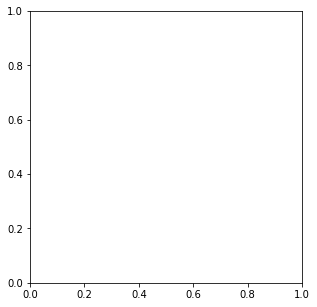

In [291]:
# in 2D?
xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
bw = 0.3

f, axes = plt.subplots(1, 1, figsize=(14, 5))

kde_skl = kde2D(normalise(X[:, 0]), normalise(X[:, 1]), bw)
#kde_skl = kde_skl.fit(normalise(X[:, 0]), normalise(X[:, 1]).reshape(-1, 2))

x_plot = np.linspace(xlow, xhigh, 1000)#[:, np.newaxis]
y_plot = np.linspace(ylow, yhigh, 1000)#[:, np.newaxis]

X_,Y_ = np.meshgrid(x_plot,y_plot)
Z = evaluate_kde2d(kde_skl, x_plot, y_plot)
#plt.imshow(Z,interpolation='none')

y_truth = evaluate_kde2d(kde_skl, x_plot, y_plot)

#_ = axes.hist(normalise(X[:, 0]), 100, density=True, label="Latent A", alpha=0.5, color='C1')
#axes.plot(y_plot, y_truth, color="k", lw=2, label=f'KDE with bw={bw}')

#axes.set_xlabel(r"Latent A value", fontsize=16)
#axes.set_ylabel("Normalised count", fontsize=16)
#axes.legend(fontsize=25);

### Back to MI

In [13]:
# looking at a single bin

In [14]:
samples = np.random.default_rng(42).normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))

In [15]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

total_time = time.time()
training_ll = []
validation_ll = []

patience = 2
pat_counter = 0

for radbin in range(1):
    X = np.stack((samples, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-5
    reg_covar = 1e-15
    components_range = 15
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    best_val = -np.inf

    initial_time = time.time()
    for n_components in range(1, components_range+1):
        tic = time.time()
        current_seed, current_val, current_train = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
        print(f'Total time fit the data: {time.time()-tic:.2f} s')
        # check if convergence has been reached based on val score
        validation_ll.append(current_val)
        training_ll.append(current_train)
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            pat_counter += 1
            if pat_counter >= patience:
                print(f'We would break here ({n_components} components), since we reached the patience limit')
                print('\n')

print(f'Total time fit the data: {time.time()-total_time:.2f} s')
    


Total time fit the data: 0.53 s
1 -1.0696203934048178
Total time fit the data: 1.59 s
2 -0.9943789457390634
Total time fit the data: 3.46 s
3 -0.9802592896923148
Total time fit the data: 4.84 s
4 -0.9690075741862773
Total time fit the data: 6.25 s
5 -0.9653496608445357
Total time fit the data: 7.46 s
6 -0.9645094229912973
Total time fit the data: 11.13 s
Total time fit the data: 11.57 s
We would break here (8 components), since we reached the patience limit


Total time fit the data: 14.53 s
We would break here (9 components), since we reached the patience limit


Total time fit the data: 17.30 s
We would break here (10 components), since we reached the patience limit


Total time fit the data: 20.27 s
We would break here (11 components), since we reached the patience limit


Total time fit the data: 25.05 s
We would break here (12 components), since we reached the patience limit


Total time fit the data: 29.47 s
We would break here (13 components), since we reached the patience limit

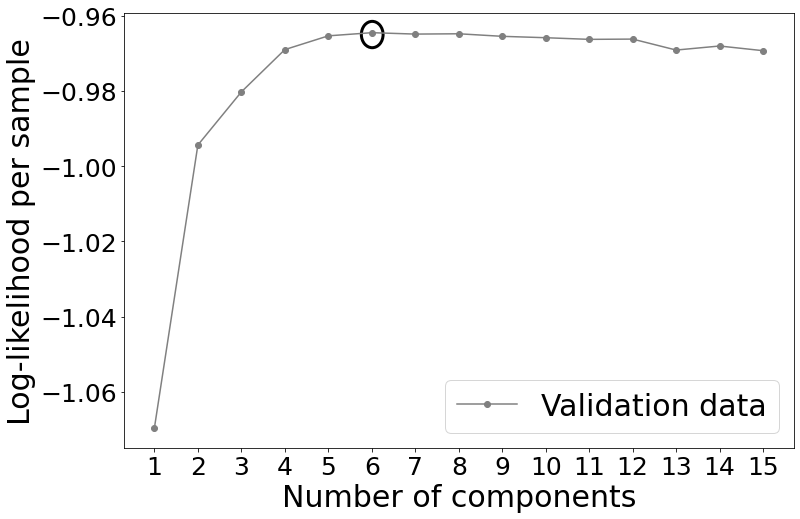

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

#ax.errorbar(np.arange(1, 19+1), np.mean(all_MI_estimates, axis=1), np.std(all_MI_estimates, axis=1), fmt='.', color='salmon', markersize=20, capsize=5, label='GMM')
#plt.plot(np.arange(1, 19+1), training_ll_1e6[:], linestyle='-', marker='o', color='salmon', label='Training')
#ax.plot(np.arange(1, components_range+1), training_ll[:], linestyle='-', marker='o', color='salmon', label='Training data')
ax.plot(np.arange(1, components_range+1), validation_ll[:], linestyle='-', marker='o', color='grey', label='Validation data')


ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel(r"Log-likelihood per sample", fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30)
ax.set_xticks(np.arange(1, components_range+1))

#ax.axhline(validation_ll[6])
import matplotlib
circle1 = matplotlib.patches.Ellipse((6.01, -0.965), 0.5, 0.007, color='black', fill=False, lw=3)
ax.add_patch(circle1);
#fig.savefig('MI_components.png', bbox_inches='tight');

In [17]:
# compare to AIC and BIC
# they both required the model to be trained on the entire dataset
# then AIC and BIC are calculated

In [18]:
# AIC, BIC
total_time = time.time()

for radbin in range(1):
    X = np.stack((samples, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'

    tol = 1e-5
    reg_covar = 1e-15
    components_range = 15

    initial_time = time.time()
    
    aics, bics = [], []
    for n_components in range(1, components_range+1):
        tic = time.time()
        
        current_seed, _, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        w_init, m_init, c_init, p_init = initialize_parameters(X, current_seed, n_components=n_components, init_type=init_type)

        fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=best_seed, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X)
        
        aic = fitted_gmm.aic(X)
        bic = fitted_gmm.bic(X)
        
        print(f'Total time fit the data: {time.time()-tic:.2f} s')

        aics.append(aic)
        bics.append(bic)


print(f'Total time fit the data: {time.time()-total_time:.2f} s')

Total time fit the data: 0.08 s
Total time fit the data: 1.69 s
Total time fit the data: 3.81 s
Total time fit the data: 5.58 s
Total time fit the data: 6.41 s
Total time fit the data: 7.82 s
Total time fit the data: 12.12 s
Total time fit the data: 12.25 s
Total time fit the data: 16.56 s
Total time fit the data: 18.16 s
Total time fit the data: 22.24 s
Total time fit the data: 26.76 s
Total time fit the data: 31.14 s
Total time fit the data: 35.93 s
Total time fit the data: 43.90 s
Total time fit the data: 244.47 s


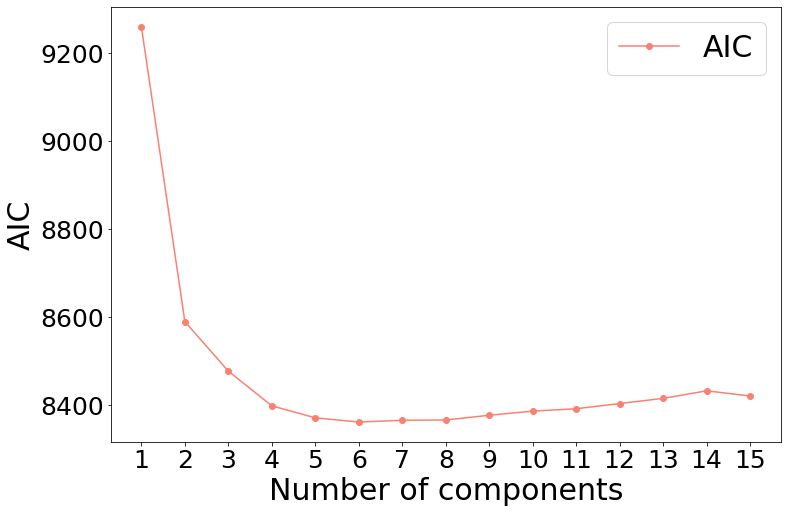

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

#ax.errorbar(np.arange(1, 19+1), np.mean(all_MI_estimates, axis=1), np.std(all_MI_estimates, axis=1), fmt='.', color='salmon', markersize=20, capsize=5, label='GMM')
#plt.plot(np.arange(1, 19+1), training_ll_1e6[:], linestyle='-', marker='o', color='salmon', label='Training')
ax.plot(np.arange(1, components_range+1), aics[:], linestyle='-', marker='o', color='salmon', label='AIC')


ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel(r"AIC", fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30)
ax.set_xticks(np.arange(1, components_range+1))

#ax.axhline(validation_ll[6])
import matplotlib
circle1 = matplotlib.patches.Ellipse((6, 5100), 0.5, 40, color='black', fill=False, lw=3)
ax.add_patch(circle1);
#fig.savefig('MI_components.png', bbox_inches='tight');

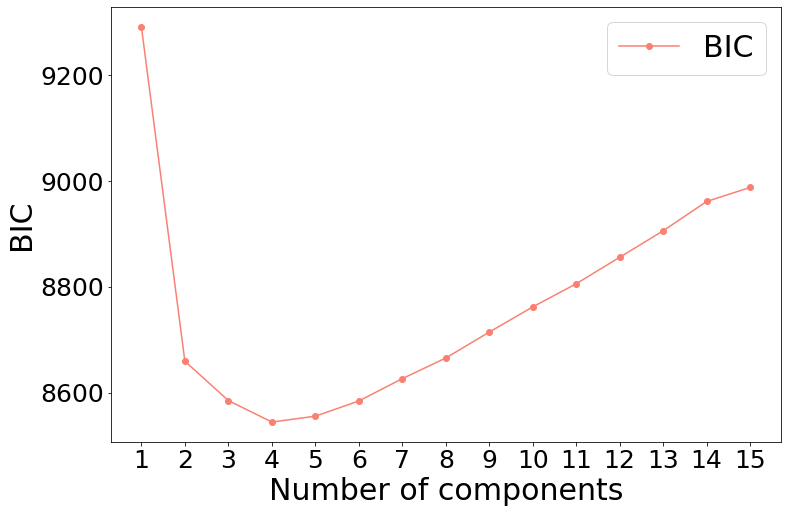

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

#ax.errorbar(np.arange(1, 19+1), np.mean(all_MI_estimates, axis=1), np.std(all_MI_estimates, axis=1), fmt='.', color='salmon', markersize=20, capsize=5, label='GMM')
#plt.plot(np.arange(1, 19+1), training_ll_1e6[:], linestyle='-', marker='o', color='salmon', label='Training')
ax.plot(np.arange(1, components_range+1), bics[:], linestyle='-', marker='o', color='salmon', label='BIC')


ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel(r"BIC", fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=30)
ax.set_xticks(np.arange(1, components_range+1))

#ax.axhline(validation_ll[6])
import matplotlib
circle1 = matplotlib.patches.Ellipse((7, -0.5845), 0.5, 0.007, color='black', fill=False, lw=3)
ax.add_patch(circle1);
#fig.savefig('MI_components.png', bbox_inches='tight');

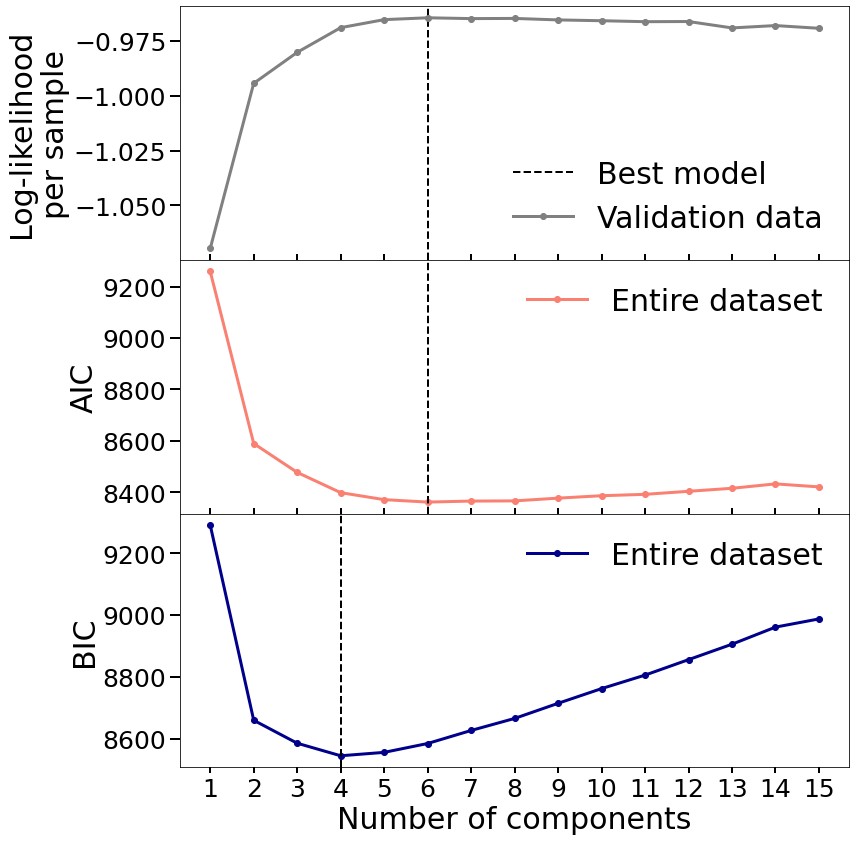

In [21]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

ax.axvline(6, color='k', lw=2, ls='--', label='Best model')
ax.plot(np.arange(1, components_range+1), validation_ll, lw=3, linestyle='-', marker='o', color='grey', label='Validation data')
ax.set_ylabel("Log-likelihood\nper sample", fontsize=30)

ax.set_xticks(np.arange(1, components_range+1))
ax.tick_params(axis='x', which='both', labelsize=25, direction="in", length=6, width=2)
ax.tick_params(axis='y', which='both', labelsize=25, length=10, width=2)

ax.legend(fontsize=30, frameon=False)
#.add_patch(circle1)

ax1.plot(np.arange(1, components_range+1), aics[:], lw=3, linestyle='-', marker='o', color='salmon', label='Entire dataset')
ax1.set_ylabel(r"AIC", fontsize=30)

ax1.tick_params(axis='x', which='both', labelsize=25, direction="in", length=6, width=2)
ax1.tick_params(axis='y', which='both', labelsize=25, length=10, width=2)
ax1.set_xticks(np.arange(1, components_range+1))

#circle1 = matplotlib.patches.Ellipse((6, 5100), 0.5, 40, color='black', fill=False, lw=3)
#ax1.add_patch(circle1);
ax1.axvline(6, color='k', lw=2, ls='--')
ax1.legend(fontsize=30, frameon=False)

ax2.plot(np.arange(1, components_range+1), bics[:], lw=3, linestyle='-', marker='o', color='darkblue', label='Entire dataset')

ax2.set_xlabel('Number of components', fontsize=30)
ax2.set_ylabel(r"BIC", fontsize=30)

ax2.tick_params(axis='x', which='both', labelsize=25, length=6, width=2)
ax2.tick_params(axis='y', which='both', labelsize=25, length=10, width=2)
ax2.set_xticks(np.arange(1, components_range+1))
ax2.axvline(4, color='k', lw=2, ls='--')
ax2.legend(fontsize=30, frameon=False)

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('val_AIC_BIC.png', bbox_inches='tight');

In [23]:
np.save('./validation_ll.npy', validation_ll)
np.save('./aics.npy', aics)
np.save('./bics.npy', bics)

In [233]:
total_time = time.time()
samples = np.random.default_rng(42).normal(lmean[:, 0], lstd[:, 0], len(lmean[:, 0]))

In [234]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial_ = []
for radbin in range(r_bins):
    X = np.stack((samples, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-5
    reg_covar = 1e-15
    components_range = 15
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    patience = 2
    pat_counter = 0
    best_val = -np.inf

    initial_time = time.time()
    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            # we actually include the patience here
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_.append(MI_estimates)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

1 -0.6777622850197537
2 -0.6234208607974775
3 -0.5955306396140084
4 -0.5913278425876937
5 -0.5871829121038467
6 -0.5866311592973913
Convergence reached at 6 components
Total time to run the procedure: 183.72 s

1 -0.6186492747724021
2 -0.5561362058465781
3 -0.5309414926134667
4 -0.5248826634026925
5 -0.5219672851522211
6 -0.5201742327486959
7 -0.519817810497492
9 -0.5197379309713932
Convergence reached at 8 components
Total time to run the procedure: 254.04 s

1 -0.42447364008608884
2 -0.3796916095036184
3 -0.36368828066888775
4 -0.3604040816168503
5 -0.35855676015261717
Convergence reached at 5 components
Total time to run the procedure: 115.35 s

1 -0.2937481257499705
2 -0.23949691329351652
3 -0.2187080212877308
4 -0.216271494981691
5 -0.21022386972675156
6 -0.20987162971443293
Convergence reached at 6 components
Total time to run the procedure: 128.88 s

1 -0.1755248068895198
2 -0.12035859398450467
3 -0.09925258376648209
4 -0.09803582749351027
5 -0.09652288608442754
6 -0.09620345594

In [235]:
MI_radial_ = np.array(MI_radial_)

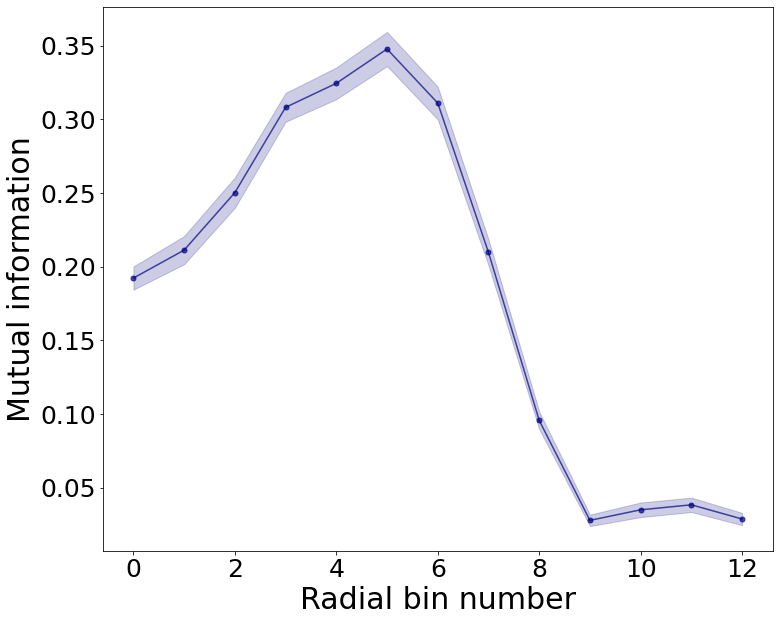

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(r_bins), np.mean(MI_radial_, axis=1), color='navy', marker='o', markersize=5, alpha=0.7)
ax.fill_between(np.arange(r_bins), np.mean(MI_radial_, axis=1)- np.std(MI_radial_, axis=1), np.mean(MI_radial_, axis=1)+ np.std(MI_radial_, axis=1), color='navy', alpha=0.2)

ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25);

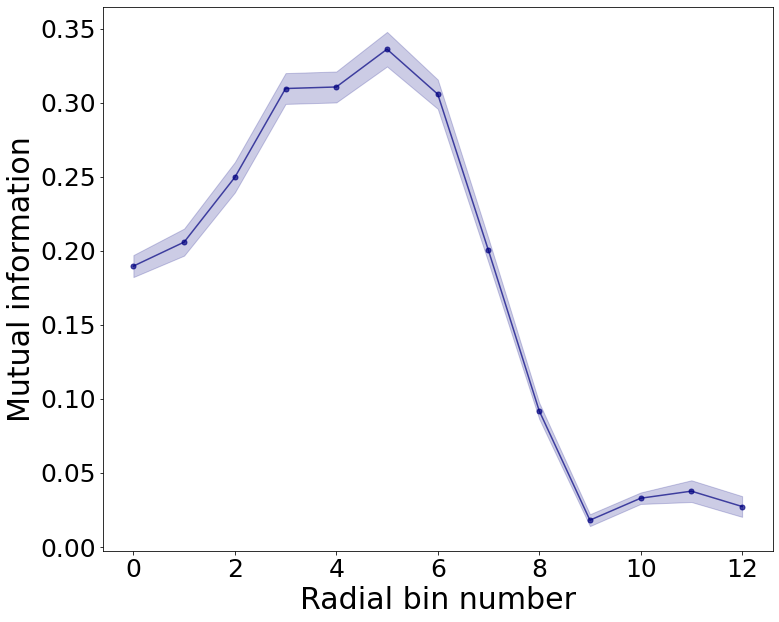

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(r_bins), MI_radial[:, 0], color='navy', marker='o', markersize=5, alpha=0.7)
ax.fill_between(np.arange(r_bins), MI_radial[:, 0]-MI_radial[:, 1], MI_radial[:, 0]+MI_radial[:, 1], color='navy', alpha=0.2)

ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25);

In [244]:
total_time = time.time()
samples_one = np.random.normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))

In [245]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial_one_ = []
for radbin in range(r_bins):
    X = np.stack((samples_one, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-5
    reg_covar = 1e-15
    components_range = 10
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    best_val = -np.inf

    patience = 2
    pat_counter = 0
    
    initial_time = time.time()
    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            # we actually include the patience here
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_one_.append(MI_estimates)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

1 -1.068844725986706
2 -0.9908191106508575
3 -0.9765854251634373
4 -0.962924905940786
5 -0.9596365620709139
6 -0.9581768149126434
7 -0.9566734803240111
Convergence reached at 7 components
Total time to run the procedure: 185.63 s

1 -1.026520962582498
2 -0.9431333329632109
3 -0.9279983087281677
4 -0.9155921296706321
5 -0.9145952788268407
6 -0.9115847490719754
7 -0.9100859074582116
8 -0.9090947767549954
Convergence reached at 8 components
Total time to run the procedure: 249.01 s

1 -0.8839509915343987
2 -0.8165963046925734
3 -0.8011551259220041
4 -0.7937093600090499
5 -0.7927244921800635
6 -0.7918340155230007
7 -0.7908789522139995
9 -0.7908292603576527
Convergence reached at 8 components
Total time to run the procedure: 233.20 s

1 -0.7985100318480808
2 -0.7188410330463492
3 -0.7068783465773185
4 -0.6976142326503245
5 -0.6933998681792746
Convergence reached at 5 components
Total time to run the procedure: 113.66 s

1 -0.6936152833397555
2 -0.6128707377536922
3 -0.6003458030237113
4 -0.

In [246]:
total_time = time.time()
samples_two = np.random.normal(lmean[:, 2], lstd[:, 2], len(lmean[:, 2]))

In [247]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial_two_ = []
for radbin in range(r_bins):
    X = np.stack((samples_two, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-5
    reg_covar = 1e-15
    components_range = 10
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    best_val = -np.inf
    
    patience = 2
    pat_counter = 0
    
    initial_time = time.time()
    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            # we actually include the patience here
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_two_.append(MI_estimates)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

Convergence reached at 4 components
Total time to run the procedure: 91.88 s

Convergence reached at 6 components
Total time to run the procedure: 150.68 s

Convergence reached at 5 components
Total time to run the procedure: 104.06 s

Convergence reached at 4 components
Total time to run the procedure: 75.65 s

Convergence reached at 5 components
Total time to run the procedure: 130.76 s

Convergence reached at 7 components
Total time to run the procedure: 202.60 s

Convergence reached at 5 components
Total time to run the procedure: 134.47 s

Convergence reached at 5 components
Total time to run the procedure: 91.43 s

Convergence reached at 5 components
Total time to run the procedure: 108.51 s

Convergence reached at 3 components
Total time to run the procedure: 47.12 s

Convergence reached at 4 components
Total time to run the procedure: 59.65 s

Convergence reached at 4 components
Total time to run the procedure: 54.21 s

Convergence reached at 3 components
Total time to run the 

In [55]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

def consistent(a, b, sa, sb, C=1):
    return np.abs(a-b) / np.sqrt(sa**2+sb**2) <= C

MI_radial_one = []
samples_one = np.random.normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))

for radbin in range(r_bins):
    X = np.stack((samples_one, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-6
    reg_covar = 1e-6
    components_range = 8
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    initial_time = time.time()
    for n_components in range(1, components_range+1):
        MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
        print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
        all_MI_estimates[n_components-1] = MI_estimates
        
        # stop if converged
        if n_components > 1:
            if consistent(np.mean(MI_estimates), np.mean(all_MI_estimates[n_components-2]), np.std(MI_estimates), np.std(all_MI_estimates[n_components-2])):
                print(f'Reached convergence at {n_components-1} components')
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_one.append([np.mean(all_MI_estimates[n_components-2]), np.std(all_MI_estimates[n_components-2])])

Total time to run with fixed number of components: 3.38 s
1 0.005358959138768104 0.0016598560364986241
Total time to run with fixed number of components: 29.73 s
2 0.02445487025531169 0.0028780772386648953
Total time to run with fixed number of components: 66.79 s
3 0.022495458686263552 0.0034207109412083218
Reached convergence at 2 components
Total time to run the procedure: 99.91 s

Total time to run with fixed number of components: 3.34 s
1 0.003950043455613086 0.0013749311612644124
Total time to run with fixed number of components: 28.39 s
2 0.027792992442230352 0.0032993644013150636
Total time to run with fixed number of components: 65.17 s
3 0.022910713715966032 0.005321391031246093
Reached convergence at 2 components
Total time to run the procedure: 96.91 s

Total time to run with fixed number of components: 3.35 s
1 0.0033156358905041187 0.001371334227761506
Total time to run with fixed number of components: 29.93 s
2 0.02080296617399954 0.0029263891079825124
Total time to run 

In [56]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

def consistent(a, b, sa, sb, C=1):
    return np.abs(a-b) / np.sqrt(sa**2+sb**2) <= C

MI_radial_two = []
samples_two = np.random.normal(lmean[:, 2], lstd[:, 2], len(lmean[:, 2]))

for radbin in range(r_bins):
    X = np.stack((samples_two, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-6
    reg_covar = 1e-6
    components_range = 8
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    initial_time = time.time()
    for n_components in range(1, components_range+1):
        MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
        print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
        all_MI_estimates[n_components-1] = MI_estimates
        
        # stop if converged
        if n_components > 1:
            if consistent(np.mean(MI_estimates), np.mean(all_MI_estimates[n_components-2]), np.std(MI_estimates), np.std(all_MI_estimates[n_components-2])):
                print(f'Reached convergence at {n_components-1} components')
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_two.append([np.mean(all_MI_estimates[n_components-2]), np.std(all_MI_estimates[n_components-2])])

Total time to run with fixed number of components: 3.34 s
1 0.012491616674863147 0.0022495192344840166
Total time to run with fixed number of components: 41.39 s
2 0.014168006278725548 0.002239664711151972
Reached convergence at 1 components
Total time to run the procedure: 44.73 s

Total time to run with fixed number of components: 3.33 s
1 0.017731364836041444 0.002333565991402466
Total time to run with fixed number of components: 40.98 s
2 0.01985770296350935 0.0026754016363301357
Reached convergence at 1 components
Total time to run the procedure: 44.32 s

Total time to run with fixed number of components: 3.33 s
1 0.020190258325662652 0.002811497079279545
Total time to run with fixed number of components: 48.55 s
2 0.0222295745021178 0.002961589973309704
Reached convergence at 1 components
Total time to run the procedure: 51.89 s

Total time to run with fixed number of components: 3.34 s
1 0.02077832248596799 0.0029927063643538404
Total time to run with fixed number of components:

In [248]:
MI_radial_one_ = np.array(MI_radial_one_)
MI_radial_two_ = np.array(MI_radial_two_)

In [56]:
np.save('./haloes_MI_latent0_newproc_noreg.npy', MI_radial_)
np.save('./haloes_MI_latent1_newproc_noreg.npy', MI_radial_one_)
np.save('./haloes_MI_latent2_newproc_noreg.npy', MI_radial_two_)

In [251]:
MI_radial = np.load('./haloes_MI_latent0_newproc.npy')
MI_radial_one = np.load('./haloes_MI_latent1_newproc.npy')
MI_radial_two = np.load('./haloes_MI_latent2_newproc.npy')

In [324]:
np.mean(MI_radial, axis=1), np.std(MI_radial, axis=1)

(array([0.19331591, 0.21480568, 0.25429444, 0.31789941, 0.32313564,
        0.34703368, 0.31885324, 0.20063675, 0.08988264, 0.02725249,
        0.03503241, 0.03934085, 0.02359717]),
 array([0.00764843, 0.00886303, 0.01033846, 0.01000422, 0.01035216,
        0.01153276, 0.01123227, 0.00854273, 0.00641029, 0.00410942,
        0.0046671 , 0.00531589, 0.00377928]))

In [202]:
np.std(MI_radial, axis=1), np.std(MI_radial_, axis=1)

(array([0.00764843, 0.00886303, 0.01033846, 0.01000422, 0.01035216,
        0.01153276, 0.01123227, 0.00854273, 0.00641029, 0.00410942,
        0.0046671 , 0.00531589, 0.00377928]),
 array([0.00787541, 0.00778235, 0.01022138, 0.0064864 , 0.00902594,
        0.00697909, 0.0068681 , 0.00666072, 0.00638563, 0.00345911,
        0.00481067, 0.00556097, 0.00356625]))

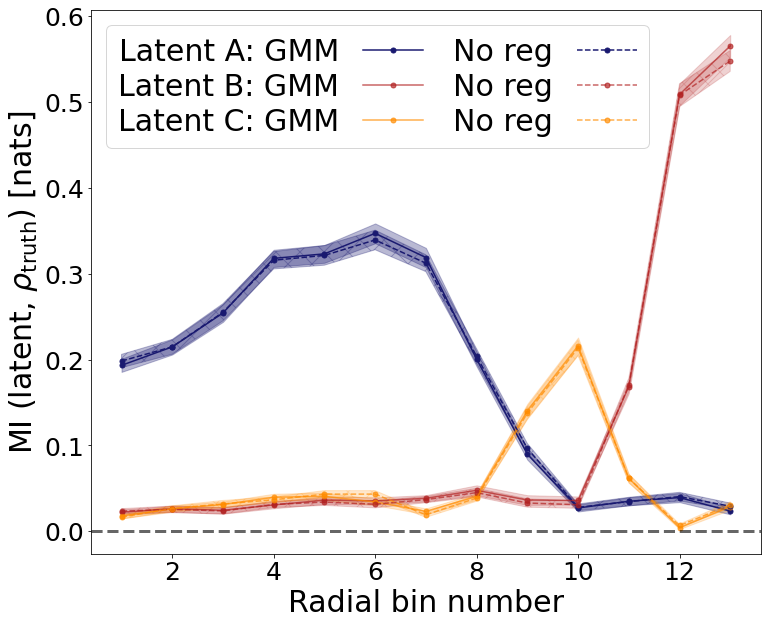

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)



#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")


ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)


#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)


ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='No reg', ls='--')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_, axis=1)- np.std(MI_radial_, axis=1), np.mean(MI_radial_, axis=1)+np.std(MI_radial_, axis=1), color='midnightblue', alpha=0.3, hatch='X')


ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one_, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='No reg', ls='--')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one_, axis=1)- np.std(MI_radial_one_, axis=1), np.mean(MI_radial_one_, axis=1)+ np.std(MI_radial_one_, axis=1), color='firebrick', alpha=0.2, hatch='X')



ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two_, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='No reg', ls='--')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two_, axis=1)- np.std(MI_radial_two_, axis=1), np.mean(MI_radial_two_, axis=1)+ np.std(MI_radial_two_, axis=1), color='darkorange', alpha=0.2, hatch='X')



#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.1, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI (latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False);
#fig.savefig('MI_trend.png', bbox_inches='tight');

In [320]:
KDE_02 = np.load('mi_truth_latents_epoch_27_bw_0.2.npy')[0].T
KDE_03 = np.load('mi_truth_latents_epoch_27_bw_0.3.npy')[0].T
KDE_01 = np.load('mi_truth_latents_epoch_27_bw_0.1.npy')[0].T

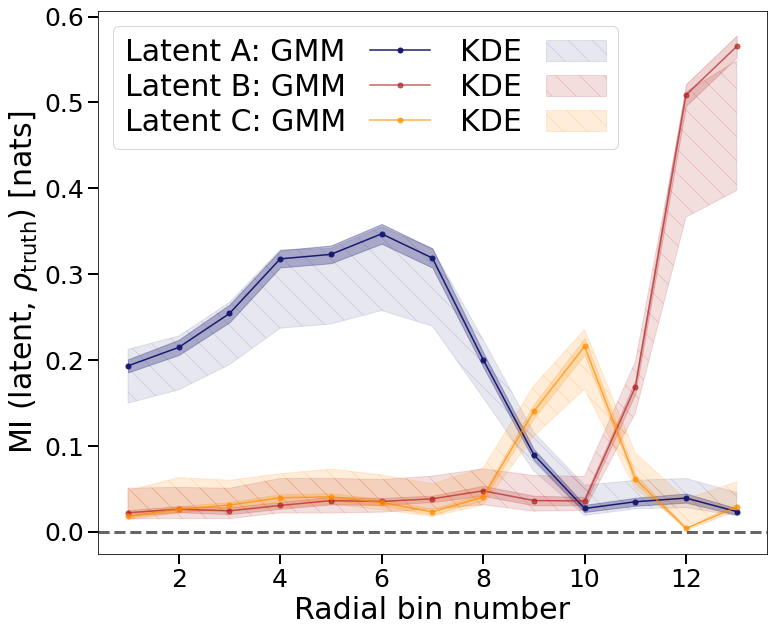

In [371]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI (latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False);
fig.savefig('MI_trend.png', bbox_inches='tight');

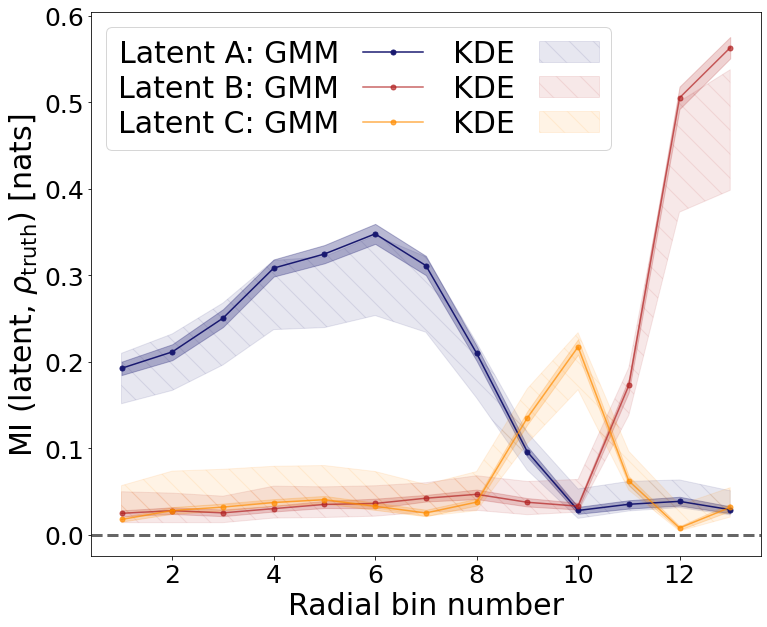

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_, axis=1)- np.std(MI_radial_, axis=1), np.mean(MI_radial_, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one_, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one_, axis=1)- np.std(MI_radial_one_, axis=1), np.mean(MI_radial_one_, axis=1)+ np.std(MI_radial_one_, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two_, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two_, axis=1)- np.std(MI_radial_two_, axis=1), np.mean(MI_radial_two_, axis=1)+ np.std(MI_radial_two_, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.1, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI (latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False);
#fig.savefig('MI_trend.png', bbox_inches='tight');

### Also look at disentanglement between latents

In [269]:
# let's look at the disentanglement among latents
# we use a simple way to stop adding components, only for the sake of this argument

MI_latents_ = np.zeros((3, 3, n_bootstrap))

for latbin1 in range(3):
    samples1 = np.random.default_rng(42).normal(lmean[:, latbin1], lstd[:, latbin1], len(lmean[:, latbin1]))
    for latbin2 in range(3):
        if latbin2 <= latbin1:
            continue
        samples2 = np.random.default_rng(420).normal(lmean[:, latbin2], lstd[:, latbin2], len(lmean[:, latbin2]))

        X = np.stack((samples1, samples2), axis=0).T

        # now we do this for many components, from 1 to 15
        n_inits = 5
        n_folds = 3
        init_type = 'random_sklearn'
        n_bootstrap = 100
        MC_samples = 1e5
        tol = 1e-5
        reg_covar = 1e-15
        components_range = 15
        all_MI_estimates = np.zeros((components_range, n_bootstrap))

        best_val = -np.inf

        initial_time = time.time()
        for n_components in range(1, components_range+1):
            current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                               init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                               MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

            # check if convergence has been reached based on val score
            if current_val > best_val:
                best_val = current_val
                best_seed = current_seed
                print(n_components, best_val)
            else:
                # if val score has not increased, then we should stop and calculate MI with the previous parameters
                best_components = n_components-1
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

        print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
        print()
        MI_latents_[latbin1, latbin2] = MI_estimates
        print(np.mean(MI_estimates))



1 -2.6971459705020853
2 -2.630514501209495
3 -2.605403907870081
4 -2.5871216617314197
5 -2.5812132898541438
Convergence reached at 5 components
Total time to run the procedure: 148.54 s

0.0828080908639161
1 -2.658254255533271
2 -2.615094524750488
3 -2.60979519358065
4 -2.606019483710971
Convergence reached at 4 components
Total time to run the procedure: 77.26 s

0.033233255698051856
1 -2.7953180779160864
2 -2.761587652817731
3 -2.758395449615625
Convergence reached at 3 components
Total time to run the procedure: 47.27 s

0.011611686547186344


In [272]:
np.mean(MI_latents_, axis=2), np.std(MI_latents_, axis=2)

(array([[0.        , 0.08280809, 0.03323326],
        [0.        , 0.        , 0.01161169],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.00613601, 0.0036631 ],
        [0.        , 0.        , 0.00207279],
        [0.        , 0.        , 0.        ]]))

In [206]:
np.mean(MI_latents, axis=2), np.std(MI_latents, axis=2)

(array([[16.62771415,  0.13495647,  0.05122183],
        [ 0.13592195, 16.83556091,  0.01730964],
        [ 0.05195232,  0.01705542, 16.80096306]]),
 array([[0.014522  , 0.00701393, 0.01399332],
        [0.00685757, 0.01376286, 0.00313611],
        [0.01402807, 0.00311399, 0.04324437]]))

In [207]:
np.mean(MI_latents_, axis=2), np.std(MI_latents_, axis=2)

(array([[1.26797972, 0.10658987, 0.05018428],
        [0.10576829, 1.36990073, 0.01979577],
        [0.0515408 , 0.02251378, 0.64006862]]),
 array([[0.01677768, 0.00618869, 0.00443976],
        [0.00673588, 0.01616275, 0.00278057],
        [0.00477583, 0.00335025, 0.01473933]]))

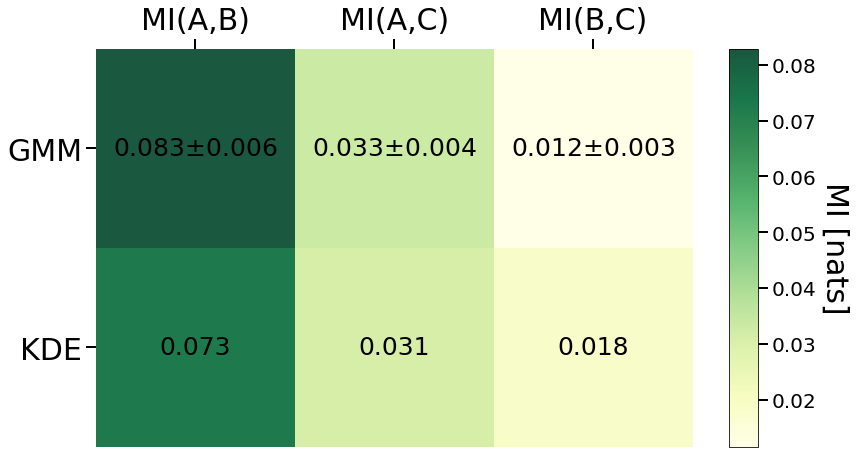

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=30)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=30)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=30)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if i == 0:
                text = im.axes.text(j, i, valfmt(data[i, j], None)+'$\pm$'+valfmt(gmm_mi_std[j], None), **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

vegetables = ["GMM", "KDE"]
farmers = ["MI(A,B)", "MI(A,C)", "MI(B,C)"]

gmm_mi = np.array([[1.26797972, 0.0828080908639161, 0.033233255698051856],
        [0.10576829, 1.36990073, 0.011611686547186344],
        [0.0515408 , 0.02251378, 0.64006862]])

gmm_mi_std = np.array([[0.01677768, 0.00618869, 0.00443976],
        [0.00673588, 0.01616275, 0.00278057],
        [0.00477583, 0.00335025, 0.01473933]])

harvest = np.array([[gmm_mi[0, 1], gmm_mi[0, 2], gmm_mi[1, 2]],
                    [0.07259258250353734, 0.030650826154068122, 0.018449264174621963]])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, gmm_mi_std=[gmm_mi_std[0, 1], gmm_mi_std[0, 2], gmm_mi_std[1, 2]], valfmt="{x:.3f}", fontsize=25)

fig.tight_layout()

In [19]:
"{x:.3f}"(data[i, j], None)

NameError: name 'data' is not defined

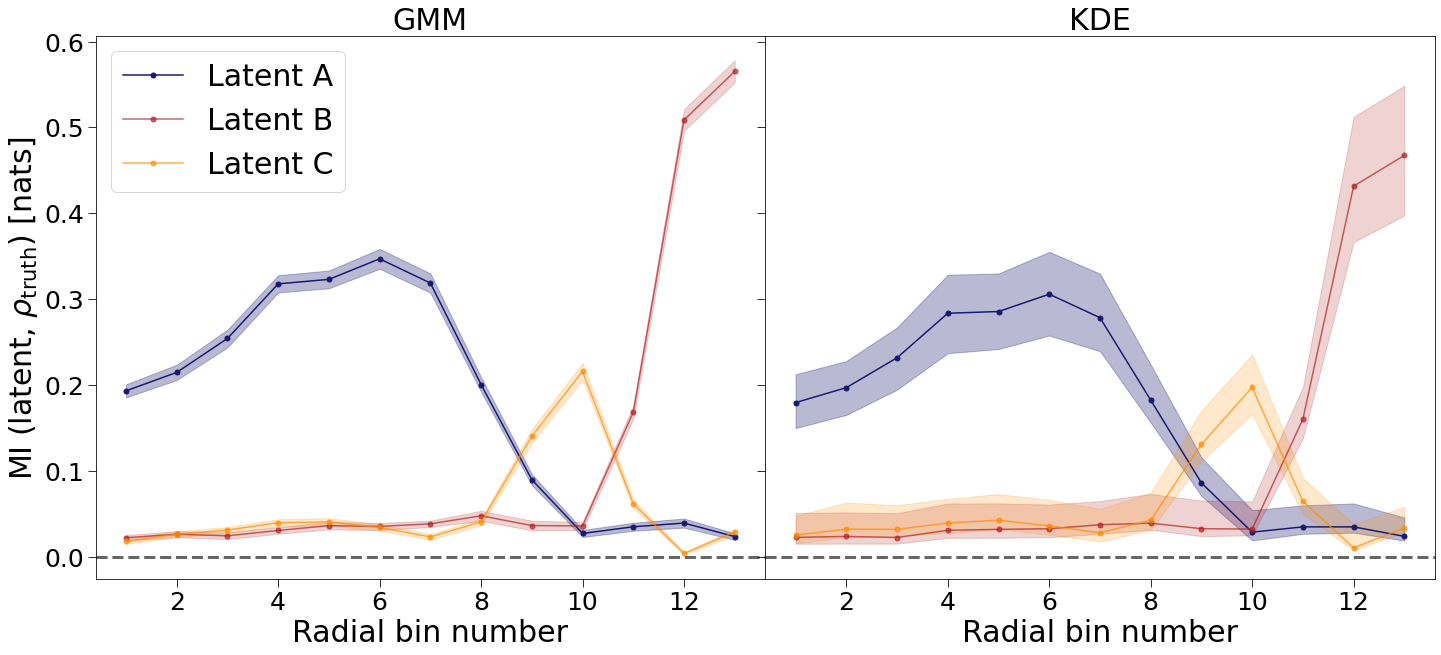

In [64]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)

ax1.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=1)
ax1.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.3)

ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

ax1.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.7)
ax1.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.2)

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

ax1.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.7)
ax1.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.2)


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI (latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)
ax.set_title('GMM', fontsize=30)
ax1.set_title('KDE', fontsize=30)

ax.tick_params(axis='both', which='major', size=8, labelsize=25)
ax1.tick_params(axis='both', which='major', size=8, labelsize=25)

ax1.set_xlabel('Radial bin number', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=25)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax1.axhline(0, ls='--', lw=3, color='k', alpha=0.6)

ax.legend(fontsize=30)
plt.subplots_adjust(wspace=0, hspace=0.0)
#fig.savefig('MI_trend.png', bbox_inches='tight');

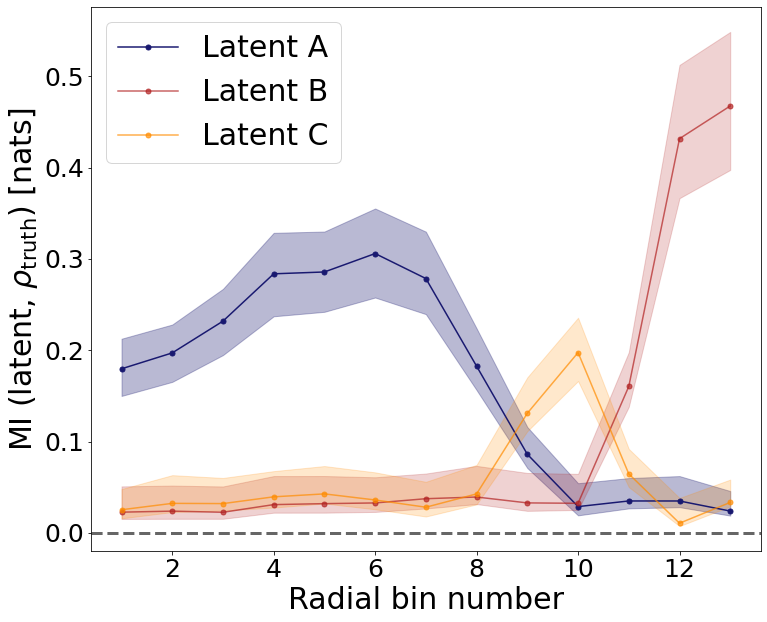

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A')
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.3)

ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B')
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.2)

ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C')
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.2)

ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI (latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30)
#fig.savefig('MI_trend.png', bbox_inches='tight');

In [67]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

for radbin in range(11, 12):
    X = np.stack((samples_two, truth[radbin]), axis=0).T

    # now we do this for many components, from 1 to 8
    n_inits = 5
    n_folds = 3
    init_type = 'random_sklearn'
    n_bootstrap = 100
    MC_samples = 1e5
    tol = 1e-6
    reg_covar = 1e-6
    components_range = 8
    all_MI_estimates = np.zeros((components_range, n_bootstrap))

    initial_time = time.time()
    for n_components in range(1, components_range+1):
        MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
        print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
        all_MI_estimates[n_components-1] = MI_estimates
        
        # stop if converged
        if n_components > 1:
            if consistent(np.mean(MI_estimates), np.mean(all_MI_estimates[n_components-2]), np.std(MI_estimates), np.std(all_MI_estimates[n_components-2])):
                print(f'Reached convergence at {n_components-1} components')
                break

    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()

Total time to run with fixed number of components: 6.28 s
1 0.00329621088831123 0.0014068495016476923
Total time to run with fixed number of components: 46.23 s
2 0.005332025172059617 0.001664911995129662
Reached convergence at 1 components
Total time to run the procedure: 52.53 s



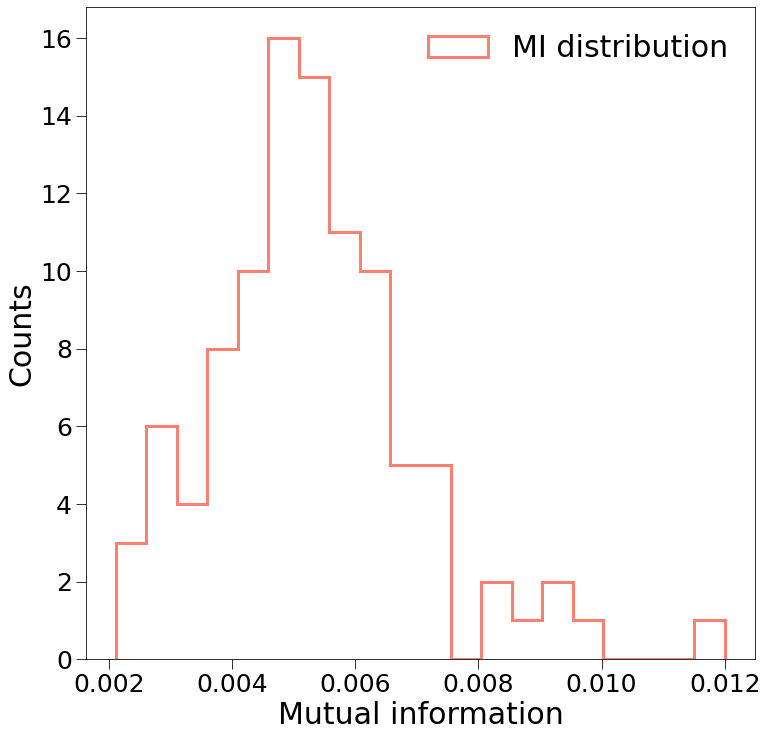

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.hist(all_MI_estimates[1], histtype='step', color='salmon', lw=3, bins=bins, label='MI distribution')

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30);

In [ ]:
# missing:
# timing
# comparison with Luisa's values
# stop using 1 std dev for convergence, use overfitting instead

### Calculation of Luisa's values

In [6]:
# A different approach is to use the fact that mutual information is defined as the KL divergence 
# between the joint distribution of two random variables p(x,y) and the product of their marginals p(x)p(y).
# I use KDEs to turn a set of discrete samples into continuous distributions

def mutual_information_cont(x, y, xlow=9, xhigh=16, ylow=9, yhigh=16, bandwidth=0.1):
    # KL divergence between joint probability distribution p(x, y) and the product of their marginals p(x)p(y).
    pxy = kde2D(x, y, bandwidth)
    print("Fitted 2D kde to joint distributions")
    px = kde1D(x, bandwidth)
    py = kde1D(y, bandwidth)
    print("Fitted 1D kdes for each marginal distributions")
    return KL_div_continuous(pxy, px, py, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)


def kde1D(x, bandwidth, **kwargs):
    """Build 1D kernel density estimate (KDE)."""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl = kde_skl.fit(x.reshape(-1, 1))
    return kde_skl


def evaluate_kde1d(fitted_kde, xx):
    """Evaluate fitted 1D KDE at position xx."""
    z = np.exp(fitted_kde.score_samples(np.array([xx]).reshape(-1, 1)))
    return z


def kde2D(x, y, bandwidth, **kwargs):
    """Build 2D kernel density estimate (KDE)."""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.vstack([y, x]).T)
    return kde_skl


def evaluate_kde2d(fitted_kde, xx, yy):
    """Evaluate fitted 2D KDE at position xx."""
    xy_sample = np.vstack([yy, xx]).T
    z = np.exp(fitted_kde.score_samples(xy_sample))
    return z


def integrand(fitted_pxy, fitted_px, fitted_py, x, y):
    pxy = evaluate_kde2d(fitted_pxy, x, y)
    px = evaluate_kde1d(fitted_px, x)
    py = evaluate_kde1d(fitted_py, y)
    nsz = pxy != 0
    value = pxy[nsz] * (np.log(pxy[nsz]) - np.log(px[nsz] * py[nsz]))
    # seems needed to avoid errors in the integration, when all values are 0
    #if not value.size > 0:
    #    return 0
    return value

def KL_div_continuous(fitted_pxy, fitted_px, fitted_py, xlow=9, xhigh=16, ylow=9, yhigh=16):
    func = lambda y, x: integrand(fitted_pxy, fitted_px, fitted_py, x, y)
    return integrate.dblquad(func, xlow, xhigh, lambda x: ylow, lambda x: yhigh)


In [7]:
# This is an array of ground truth density profiles of halos. 
# It is an MxN matrix where M is the number of radial bins and N in is the number of halos.
# For example, truth[:, i] gives you the density profile for halo i and 
# truth[j] gives you the distribution of rho in radial bin j for all halos.

truth = np.load("./true_log_rho_per_radial_bin_sim11_testset.npy")
truth.shape

lmean, lstd = np.load("./latent_mean_11_testset_epoch_27.npy"), np.load("./latent_std_11_testset_epoch_27.npy")

latent_variable = 0
samples = np.random.normal(lmean[:, latent_variable], lstd[:, latent_variable], len(lmean[:, latent_variable]))

X = np.stack((samples, truth[0]), axis=0).T

# Compute the mutual information between ground truth bin 0 and latent 0 samples using KDE

def normalise(X):
    return (X - np.mean(X))/np.std(X)

xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()

tic = time.time()
kde_estimate = mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=0.1, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]

print(time.time()-tic)

Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
716.82927775383


In [38]:
# Compute the mutual information between ground truth bin 0 and latent 0 samples using KDE

def normalise(X):
    return (X - np.mean(X))/np.std(X)

tic = time.time()

samples = np.random.normal(lmean[:, 0], lstd[:, 0], len(lmean[:, 0]))

kde_estimate_z0 = np.zeros((r_bins, 3))
for radbin in range(1):
    X = np.stack((samples, truth[radbin]), axis=0).T
    
    xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
    ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
    for i, bw in enumerate([0.3, 0.2, 0.1]):
        toc = time.time()
        kde_estimate = mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]
        print(f'Total time to make 1/3 of the bin: {time.time()-toc:.2f} s')
        kde_estimate_z0[radbin, i] = kde_estimate
        
print(f'Total time to make 1/3 of the plot: {time.time()-tic:.2f} s')

Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
Total time to make 1/3 of the bin: 74.06 s
Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
Total time to make 1/3 of the bin: 216.87 s
Fitted 2D kde to joint distributions
Fitted 1D kdes for each marginal distributions
Total time to make 1/3 of the bin: 694.65 s
Total time to make 1/3 of the plot: 985.59 s


In [ ]:
kde_estimate_z0

In [ ]:
np.save('./KDE_z0.npy', kde_estimate_z0)

In [ ]:
# Compute the mutual information between ground truth bin 0 and latent 0 samples using KDE

def normalise(X):
    return (X - np.mean(X))/np.std(X)

tic = time.time()

samples_one = np.random.normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))

kde_estimate_z1 = np.zeros((r_bins, 3))
for radbin in range(r_bins):
    X = np.stack((samples_one, truth[radbin]), axis=0).T
    
    xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
    ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
    for i, bw in enumerate([0.3, 0.2, 0.1]):
        kde_estimate = mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]
        kde_estimate_z1[radbin, i] = kde_estimate
        
print(f'Total time to make 1/3 of the plot: {time.time()-tic:.2f} s')

np.save('./KDE_z1.npy', kde_estimate_z1)

In [ ]:
# Compute the mutual information between ground truth bin 0 and latent 0 samples using KDE

def normalise(X):
    return (X - np.mean(X))/np.std(X)

tic = time.time()

samples_two = np.random.normal(lmean[:, 2], lstd[:, 2], len(lmean[:, 2]))

kde_estimate_z2 = np.zeros((r_bins, 3))
for radbin in range(r_bins):
    X = np.stack((samples_two, truth[radbin]), axis=0).T
    
    xlow, xhigh = normalise(X[:, 0]).min(), normalise(X[:, 0]).max()
    ylow, yhigh = normalise(X[:, 1]).min(), normalise(X[:, 1]).max()
    for i, bw in enumerate([0.3, 0.2, 0.1]):
        kde_estimate = mutual_information_cont(normalise(X[:, 0]), normalise(X[:, 1]), bandwidth=bw, xlow=xlow, xhigh=xhigh, ylow=ylow, yhigh=yhigh)[0]
        kde_estimate_z2[radbin, i] = kde_estimate
        
print(f'Total time to make 1/3 of the plot: {time.time()-tic:.2f} s')

np.save('./KDE_z2.npy', kde_estimate_z2)

### Regularisation

In [72]:
# now we do this for many components, from 1 to 5
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-6
components_range = 8
all_MI_estimates_reg = np.zeros((components_range, n_bootstrap))

samples = np.random.normal(lmean[:, 0], lstd[:, 0], len(lmean[:, 0]))
X = np.stack((samples, truth[0]), axis=0).T


initial_time = time.time()
for n_components in range(1, components_range+1):
    MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
    print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
    all_MI_estimates_reg[n_components-1] = MI_estimates

print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')

Total time to run with fixed number of components: 3.35 s
1 0.16693411994821106 0.007039481809250156
Total time to run with fixed number of components: 28.90 s
2 0.1880667639141791 0.007222156264186965
Total time to run with fixed number of components: 94.87 s
3 0.18865413496658723 0.007607998667111491
Total time to run with fixed number of components: 125.74 s
4 0.19262572169066783 0.007673036817870058
Total time to run with fixed number of components: 210.67 s
5 0.19404139746693277 0.007547913966795899
Total time to run with fixed number of components: 234.88 s
6 0.19232663487883658 0.007763737687700082
Total time to run with fixed number of components: 357.27 s
7 0.19452340150165626 0.007771829939449746
Total time to run with fixed number of components: 444.76 s
8 0.1967263632023384 0.007878560843447912
Total time to run the procedure: 1500.45 s


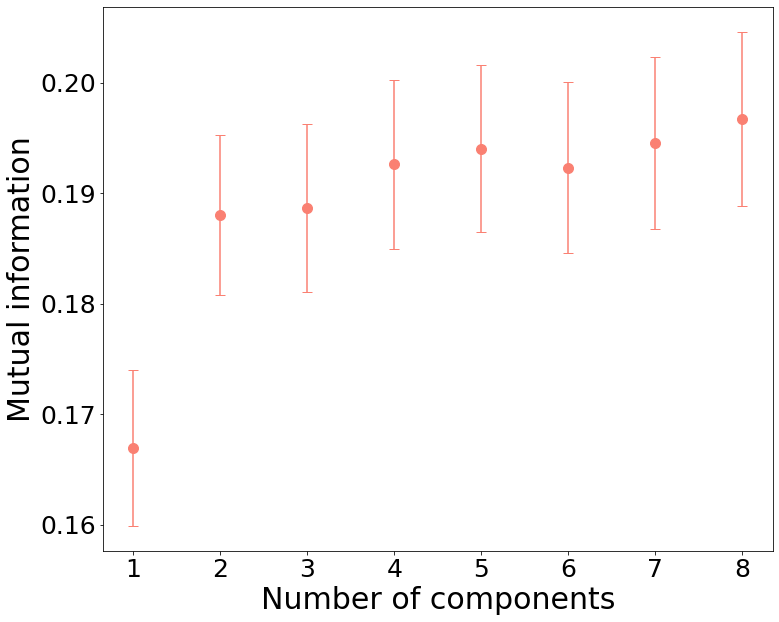

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.errorbar(np.arange(1, components_range+1), np.mean(all_MI_estimates_reg, axis=1), np.std(all_MI_estimates_reg, axis=1), fmt='.', color='salmon', markersize=20, capsize=5)

ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [76]:
# now we do this for many components, from 1 to 5
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-5
components_range = 8
all_MI_estimates_reg_ = np.zeros((components_range, n_bootstrap))


initial_time = time.time()
for n_components in range(1, components_range+1):
    MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
    print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
    all_MI_estimates_reg_[n_components-1] = MI_estimates

print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')

Total time to run with fixed number of components: 3.32 s
1 0.1668747016035109 0.007036556726893869
Total time to run with fixed number of components: 29.38 s
2 0.1872955468032128 0.007656449414843825
Total time to run with fixed number of components: 98.94 s
3 0.1903077166922931 0.007457215259447278
Total time to run with fixed number of components: 126.96 s
4 0.19246631777042975 0.00744996591048505
Total time to run with fixed number of components: 206.75 s
5 0.19393147851273215 0.007467071119831823
Total time to run with fixed number of components: 232.57 s
6 0.19207920651059562 0.007748438089700125
Total time to run with fixed number of components: 357.91 s
7 0.1941747315597841 0.00773936636796454
Total time to run with fixed number of components: 456.84 s
8 0.196257103636643 0.007834295135775807
Total time to run the procedure: 1512.67 s


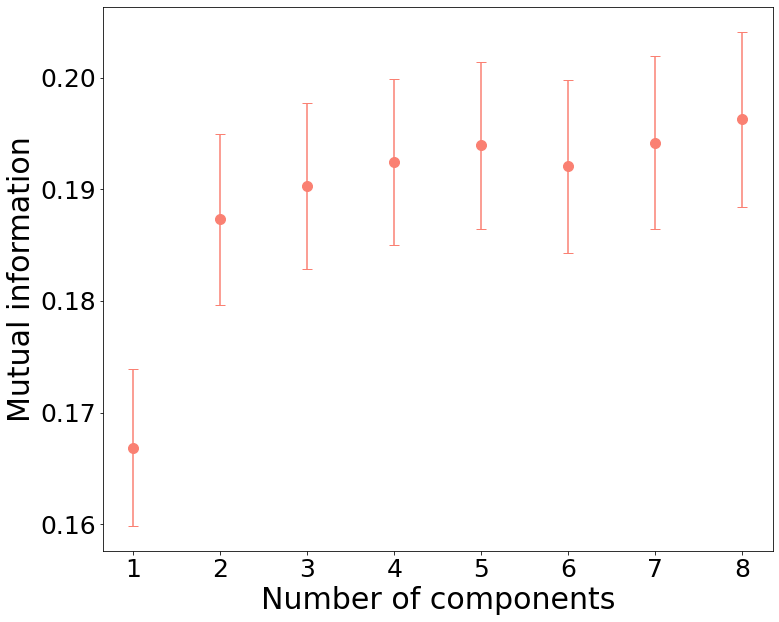

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.errorbar(np.arange(1, components_range+1), np.mean(all_MI_estimates_reg_, axis=1), np.std(all_MI_estimates_reg_, axis=1), fmt='.', color='salmon', markersize=20, capsize=5)

ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [78]:
# now we do this for many components, from 1 to 5
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-6
reg_covar = 1e-4
components_range = 8
all_MI_estimates_reg_ = np.zeros((components_range, n_bootstrap))


initial_time = time.time()
for n_components in range(1, components_range+1):
    MI_estimates = MI_procedure(X, n_components=n_components, n_folds=n_folds, init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)
    print(n_components, np.mean(MI_estimates), np.std(MI_estimates))  
    all_MI_estimates_reg_[n_components-1] = MI_estimates

print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')

Total time to run with fixed number of components: 3.35 s
1 0.16628275558643488 0.007007461570201505
Total time to run with fixed number of components: 27.10 s
2 0.18636460173471092 0.007609577233373418
Total time to run with fixed number of components: 97.03 s
3 0.1859474879415265 0.00732322372626955
Total time to run with fixed number of components: 134.15 s
4 0.19137177983902545 0.007574674618403625
Total time to run with fixed number of components: 202.69 s
5 0.18927849751077386 0.00754653586715696
Total time to run with fixed number of components: 225.32 s
6 0.19082884362747465 0.0072847033028996065
Total time to run with fixed number of components: 336.71 s
7 0.19401213764366582 0.007635316134108617
Total time to run with fixed number of components: 408.16 s
8 0.1951509232460492 0.007596474601540244
Total time to run the procedure: 1434.53 s


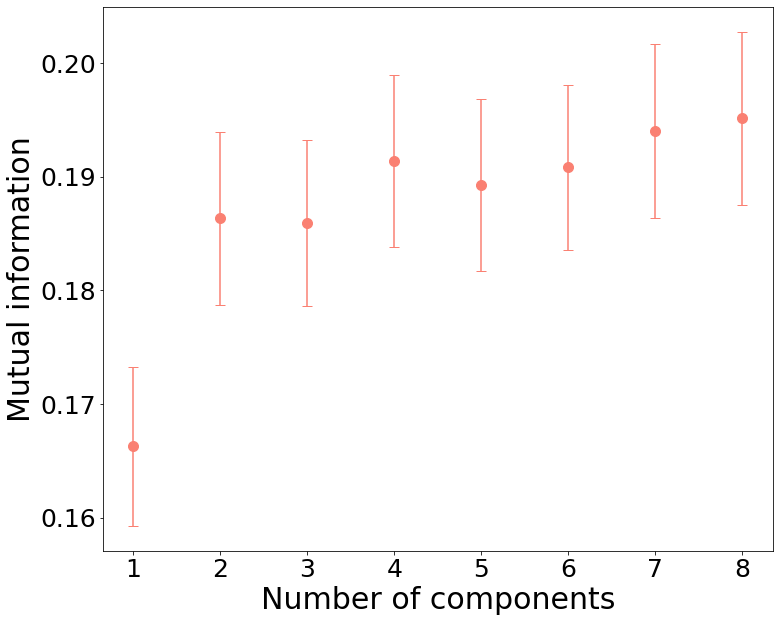

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.errorbar(np.arange(1, components_range+1), np.mean(all_MI_estimates_reg_, axis=1), np.std(all_MI_estimates_reg_, axis=1), fmt='.', color='salmon', markersize=20, capsize=5)

ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)